![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*pv-cTgMuAxVugzu0)

- **Matplotlib** es una biblioteca completa para crear visualizaciones estáticas, animadas e interactivas en Python. Sigue siendo la biblioteca de visualización de datos más utilizada. La mayoría de los servicios básicos de Matplotlib se encuentran bajo el submódulo **pyplot** y generalmente se importan en el alias **plt**:
```python
import matplotlib.pyplot as plt
```
- **Seaborn** es una biblioteca de visualización de datos de Python basada en matplotlib. Proporciona una interfaz de alto nivel para dibujar gráficos estadísticos atractivos e informativos.
- **Pandas** es una herramienta de análisis de datos que también ofrece grandes opciones para la visualización de datos. Por ejemplo, Pandas utiliza el método plot() para crear diagramas.
- **JoyPy** es un paquete Python de una sola función basado en matplotlib y pandas con un solo propósito: dibujar joyplots (también conocidas tramas de cresta).
- **pyWaffle** es un paquete Python de código abierto, con licencia MIT para trazar cartas de gofres.
- **squarify** permite crear diagramas Treemap.
- **calmap** se puede utilizar para trazar los datos de serie de tiempo de Pandas muestreados por día en un mapa de calor por año calendario.
- **statsmodels** contienen clases de modelos y funciones que son útiles para el análisis de series temporales.

## Prerequisitos
### Instalación e importación de las siguientes librerias Python

In [12]:
#!pip install joypy, pywaffle, calmap, scipy, squarify, sklearn, statsmodels

import joypy
from pywaffle import Waffle
import calmap

import numpy as np

import pandas as pd
from pandas.plotting import andrews_curves
from pandas.plotting import parallel_coordinates

from sklearn.cluster import AgglomerativeClustering
from sklearn import datasets

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
import matplotlib.patches as patches

from scipy.spatial import ConvexHull
from scipy.signal import find_peaks
from scipy.stats import sem
import scipy.cluster.hierarchy as shc

import squarify

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.seasonal import seasonal_decompose

from dateutil.parser import parse

from IPython.display import Image

In [5]:
import requests
from io import StringIO

def leer_csv_desde_url(url):
    response = requests.get(url)

    # Verifica si el servidor respondió con código 200 (OK)
    if response.status_code == 200:
        # Convierte el contenido del CSV a un DataFrame
        csv_data = StringIO(response.text)
        df = pd.read_csv(csv_data)
        return df
    else:
        raise Exception(f"Error al acceder a la URL: código {response.status_code}")


## Diagramas de dispersión

- Una diagrama de dispersión, utiliza puntos para representar valores de dos variables numéricas diferentes. La posición de cada punto en el eje **x** e **y** indica valores para un par de datos individual. Los diagramas de dispersión se utilizan para observar relaciones entre variables.
- Se puede usar matplotlib.pyplot.scatter para dibujar un diagrama de dispersión.
- Lectura y comprobación de los datos de entrada

In [7]:
PATH = 'visual/midwest_filter.csv' 
df = pd.read_csv(PATH)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PID                   332 non-null    int64  
 1   county                332 non-null    object 
 2   state                 332 non-null    object 
 3   area                  332 non-null    float64
 4   poptotal              332 non-null    int64  
 5   popdensity            332 non-null    float64
 6   popwhite              332 non-null    int64  
 7   popblack              332 non-null    int64  
 8   popamerindian         332 non-null    int64  
 9   popasian              332 non-null    int64  
 10  popother              332 non-null    int64  
 11  percwhite             332 non-null    float64
 12  percblack             332 non-null    float64
 13  percamerindan         332 non-null    float64
 14  percasian             332 non-null    float64
 15  percother             3

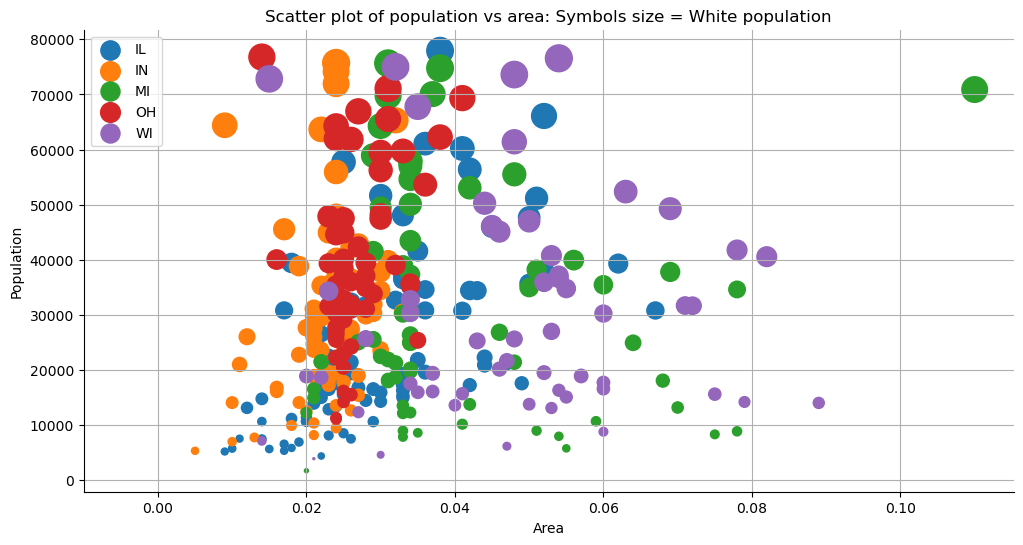

In [8]:
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1,)

# iterate over each state 
for cat in sorted(list(df["state"].unique())):
    # filter x and the y for each category
    ar = df[df["state"] == cat]["area"]
    pop = df[df["state"] == cat]["poptotal"]
    wht = df[df["state"] == cat]["popwhite"]
    
    # plot the data poptoal vs area colored by popwhite
    ax.scatter(ar, pop, label = cat, s = wht/200)
    

ax.spines["top"].set_color("None") 
ax.spines["right"].set_color("None")

# set a specific label for each axis
ax.set_xlabel("Area") 
ax.set_ylabel("Population")

ax.set_xlim(-0.01) 
ax.set_title("Scatter plot of population vs area: Symbols size = White population")
ax.legend(loc = "upper left", fontsize = 10);
plt.grid()

## Parcela de burbujas enmarcadas

- A veces se quiere mostrar un grupo de puntos dentro de un límite para enfatizar su importancia.
- En este ejemplo, se obtienen los registros del marco de datos que deben ser rodeados.

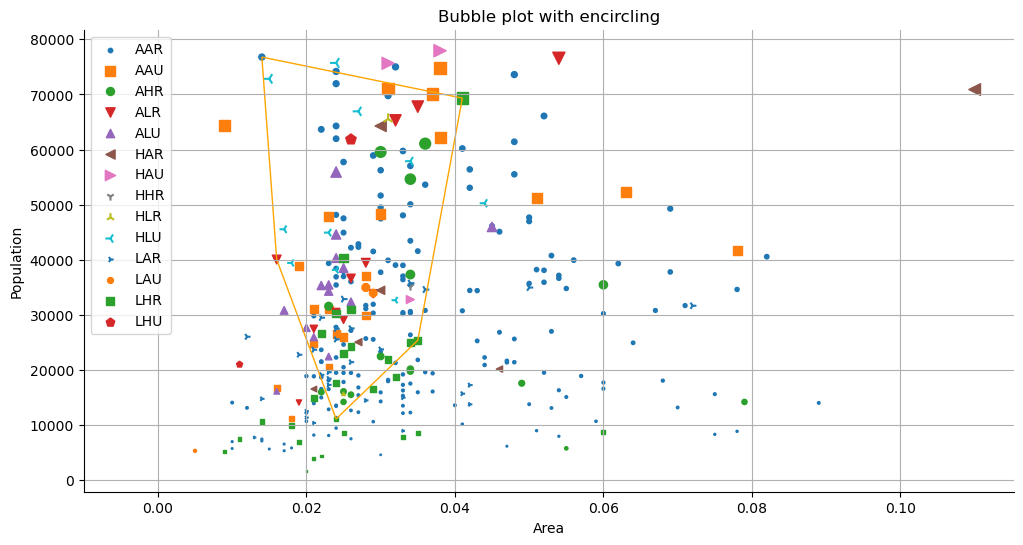

In [10]:
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1,)

# prepare the data for plotting
size_total = df["poptotal"].sum()
# we want every group to have a different marker
markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d"] 

# iterate over each category and plot the data.
for cat, marker in zip(sorted(list(df["category"].unique())), markers):
    # filter x and the y for each category
    ar = df[df["category"] == cat]["area"]
    pop = df[df["category"] == cat]["poptotal"]
    
    # this will allow us to set a specific size for each group.
    size = pop/size_total
    
    # plot the data
    ax.scatter(ar, pop, label = cat, s = size*10000, marker = marker)

# ----------------------------------------------------------------------------------------------------
# create an encircle
# based on this solution
# https://stackoverflow.com/questions/44575681/how-do-i-encircle-different-data-sets-in-scatter-plot

# steps to take:

# filter a specific group selecting state OH
encircle_data = df[df["state"] == "OH"]

# separete x and y
encircle_x = encircle_data["area"]
encircle_y = encircle_data["poptotal"]

p = np.c_[encircle_x,encircle_y]

# uing ConvexHull (we imported it before) to calculate the limits of the polygon
hull = ConvexHull(p)

# create the polygon with a specific color based on the vertices of our data/hull
poly = plt.Polygon(p[hull.vertices,:], ec = "orange", fc = "none")

# add the patch to the axes/plot)
ax.add_patch(poly)


ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

# set a specific label for each axis
ax.set_xlabel("Area")
ax.set_ylabel("Population")


ax.set_xlim(-0.01) 
ax.set_title("Bubble plot with encircling")
ax.legend(loc = "upper left", fontsize = 10);
plt.grid()

## Scatter Plot & Regresión Lineal

- Hay dos funciones en seaborn para crear un diagrama de dispersión con una línea de regresión: **regplot** y **lmplot**.
- Vamos a ver la función **lmplot** que permite crear líneas de regresión basadas en una variable categórica. Sólo tienes que pasar la variable al argumento **hue** de la función. Tener en cuenta que esta función requiere el argumento **data** con un marco de datos pandas como entrada.
- Aquí está el ejemplo de usar sns.lmplot para analizar los datos mpg.ggplot2.csv

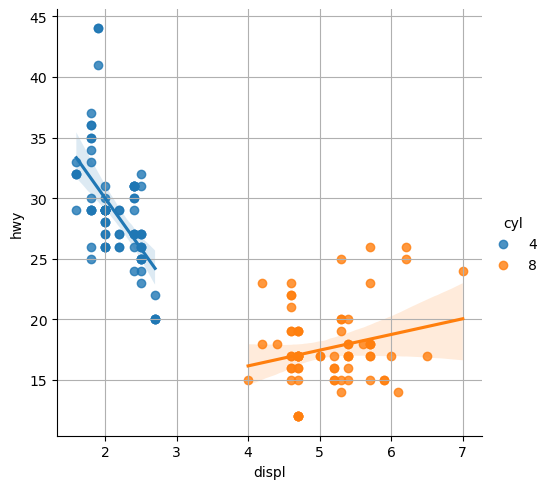

In [12]:
# get the data
PATH = 'visual/mpg_ggplot2.csv'
df = pd.read_csv(PATH)

# filter only 2 clases 
df = df[df["cyl"].isin([4,8])]

# plot the data using seaborn

sns.lmplot(x ='displ', y ='hwy', data = df,hue = "cyl")
plt.grid()

## Jittering & Strip Plot

- El gráfico **jitter** es una variante del strip plot con una mejor vista de los puntos de datos superpuestos, utilizado para visualizar distribuciones de muchos valores individuales en 1D
- Creación del gráfico jitter.

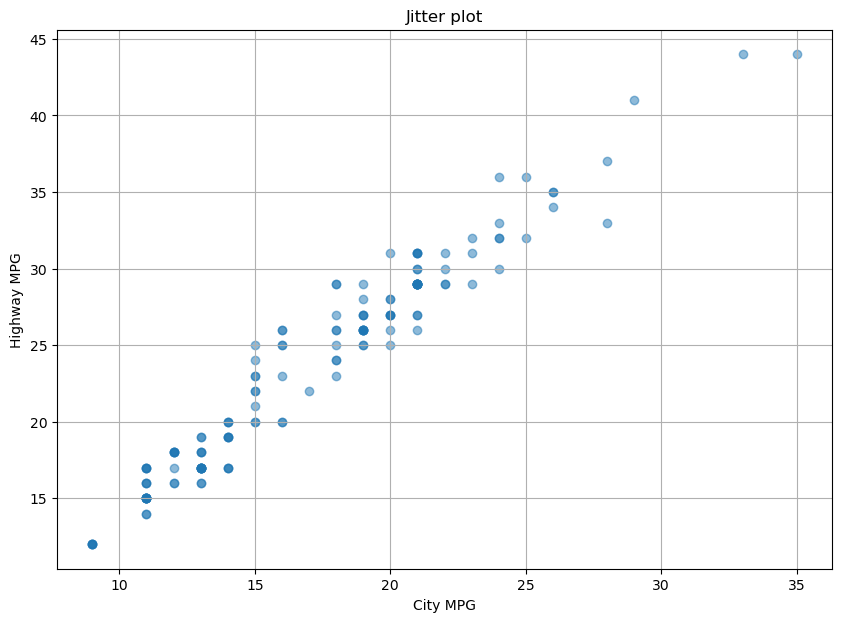

In [14]:
x = df["cty"]
y = df["hwy"]

plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.5)  # Jitter plot típico (puedes agregar ruido si quieres jitter real)
plt.title("Jitter plot")
plt.grid(True)
plt.xlabel("City MPG")
plt.ylabel("Highway MPG")
plt.show()

## Conteo de trama

- Un gráfico de **conteo de trama** es una variante del strip plot con una mejor vista de los puntos de datos superpuestos, utilizados para visualizar la distribución de muchos valores individuales en 1D.
- Crear gráfico de conteo de trama con el conjunto de datos mpg.ggplot2.csv

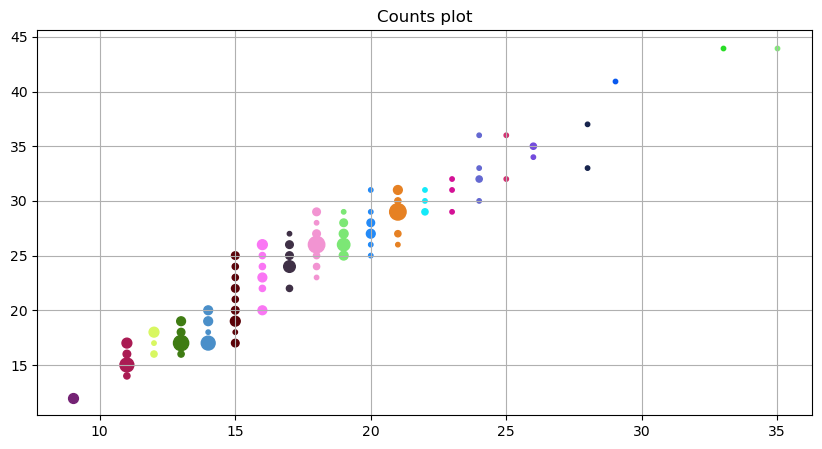

In [16]:
PATH = 'visual/mpg_ggplot2.csv'
df = pd.read_csv(PATH)
gb_df = df.groupby(["cty", "hwy"]).size().reset_index(name = "counts")

# sort the values
gb_df.sort_values(["cty", "hwy", "counts"], ascending = True, inplace = True)

# create a color for each group. 

colors = {i:np.random.random(3,) for i in sorted(list(gb_df["cty"].unique()))}

fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# iterate over each category and plot the data. This way, every group has it's own color and sizwe.
for x in sorted(list(gb_df["cty"].unique())):
    
    # get x and y values for each group
    x_values = gb_df[gb_df["cty"] == x]["cty"]
    y_values = gb_df[gb_df["cty"] == x]["hwy"]
    
    # extract the size of each group to plot
    size = gb_df[gb_df["cty"] == x]["counts"]
    
    # extract the color for each group and covert it from rgb to hex
    color = matplotlib.colors.rgb2hex(colors[x])
    
    # plot the data
    ax.scatter(x_values, y_values, s = size*10, c = color)
    

ax.set_title("Counts plot");
plt.grid()

## Histograma marginal

- Los histogramas marginales añaden histogramas al margen de cada eje de un gráfico de dispersión para analizar la distribución de cada medida.
- Crear gráfico de dispersión con histogramas marginales

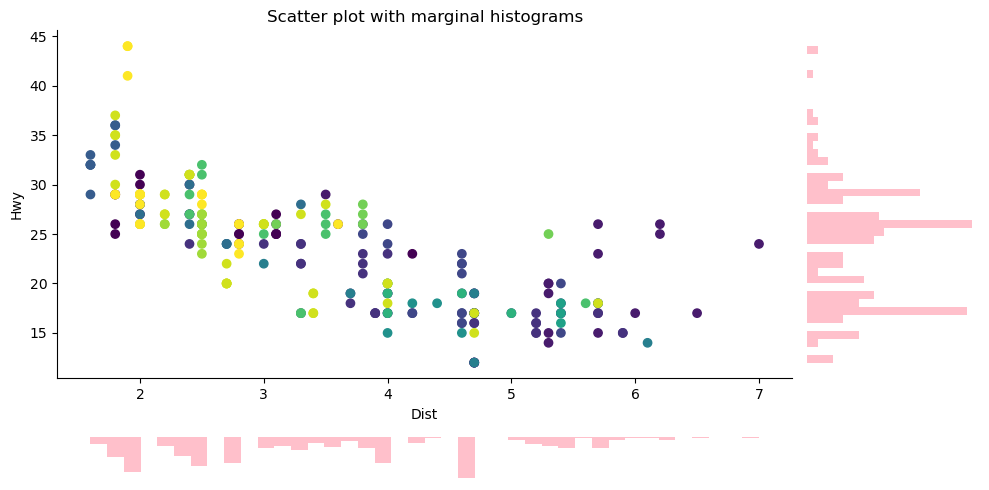

In [43]:
# get the data
PATH = 'visual/mpg_ggplot2.csv'
df = pd.read_csv(PATH)


# separate x and y
x = df["displ"]
y = df["hwy"]


fig = plt.figure(figsize = (10, 5))
# in this case we use gridspec.
# check the basics section of this kernel if you need help.
gs = fig.add_gridspec(5, 5)
ax1 = fig.add_subplot(gs[:4, :-1])

# main axis: scatter plot
# this line is very nice c = df.manufacturer.astype('category').cat.codes
# since it basically generate a color for each category
ax1.scatter(x, y, c = df.manufacturer.astype('category').cat.codes) 

# set the labels for x and y
ax1.set_xlabel("Dist")
ax1.set_ylabel("Hwy")

# set the title for the main plot
ax1.set_title("Scatter plot with marginal histograms")


ax1.spines["right"].set_color("None")
ax1.spines["top"].set_color("None")


ax2 = fig.add_subplot(gs[4:, :-1])
ax2.hist(x, 40, orientation = 'vertical', color = "pink")


ax2.invert_yaxis()


ax2.set_xticks([])
ax2.set_yticks([])

ax2.axison = False


ax3 = fig.add_subplot(gs[:4, -1])
ax3.hist(y, 40, orientation = "horizontal", color = "pink")


ax3.set_xticks([])
ax3.set_yticks([])

ax3.axison = False


fig.tight_layout()

## Boxplot Marginal

- El boxplot marginal tiene un propósito similar al histograma marginal. Sin embargo, el boxplot ayuda a identificar la mediana, los percentiles 25 y 75 de la X y la Y.
- Creación del gráfico de dispersión con boxplot marginal

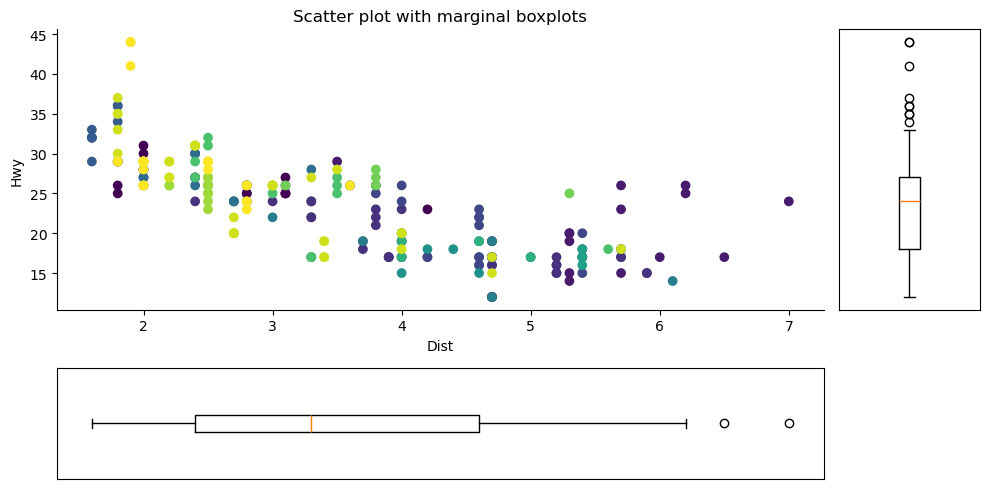

In [20]:
# get the data
PATH = 'visual/mpg_ggplot2.csv'
df = pd.read_csv(PATH)



x = df["displ"]
y = df["hwy"]

# in this plot we create the colors separatly
colors = df["manufacturer"].astype("category").cat.codes


fig = plt.figure(figsize = (10, 5))

gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:4, :-1])

# main axis: scatter plot

ax1.scatter(x, y, c = df.manufacturer.astype('category').cat.codes) 

# set the labels for x and y
ax1.set_xlabel("Dist")
ax1.set_ylabel("Hwy")

# set the title for the main plot
ax1.set_title("Scatter plot with marginal boxplots")


ax1.spines["right"].set_color("None")
ax1.spines["top"].set_color("None")


ax2 = fig.add_subplot(gs[4:, :-1])
ax2.boxplot(x, 
            vert = False,  
            whis = 0.75 # make the boxplot lines shorter
           )

ax2.set_xticks([])
ax2.set_yticks([])

# left plot
ax3 = fig.add_subplot(gs[:4, -1])
ax3.boxplot(y,  
            whis = 0.75 
           )

ax3.set_xticks([])
ax3.set_yticks([])


fig.tight_layout()

## Correlación Heatmap

- Seaborn ofrece herramientas útiles simples para crear mapas de calor de correlación.
- El mapa de calor muestra una matriz con colores que indican el grado de correlación entre las variables.
- Crear una matriz de correlación de calor usando el dataset mtcars.csv

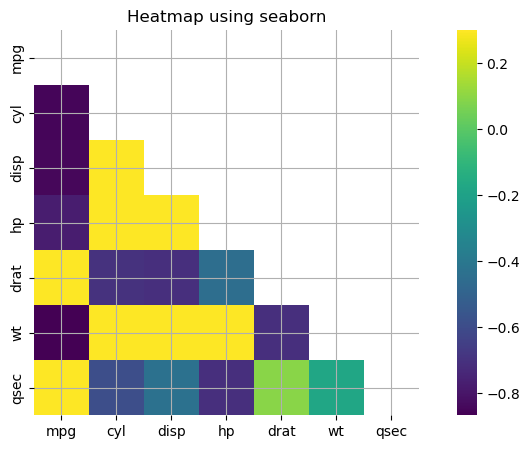

In [22]:
# get the data
PATH = 'visual/mtcars.csv'
df = pd.read_csv(PATH)

df1=df[['mpg','cyl','disp','hp','drat','wt','qsec']]

# calculate the correlation between all variables
corr = df1.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (10, 5))

# plot the data using seaborn
ax = sns.heatmap(corr, 
                 mask = mask, 
                 vmax = 0.3, 
                 square = True,  
                 cmap = "viridis")
# set the title for the figure
ax.set_title("Heatmap using seaborn");
plt.grid()

## Gráfico de Barras Divergentes

- Para ver cómo los elementos varians en función de una sola métrica y visualizar el orden y la cantidad de esta varianza, las barras divergentes es una gran herramienta.
- Gráfico de Barras Divergentes se utilizan para facilitar la comparación de múltiples grupos. Su diseño permite comparar valores numéricos de varios grupos. También ayuda a visualizar rápidamente las respuestas favorables, desfavorables o positivas y negativas.
- Crear Gráfico de Barras Divergentes en matplotlib utilizando el dataset mtcars.csv

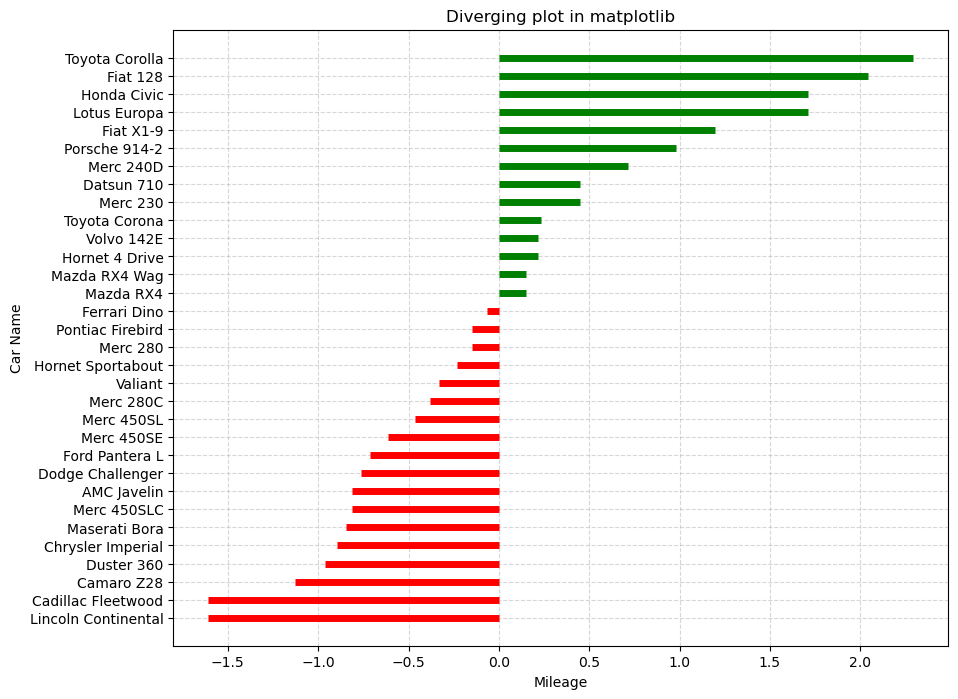

In [24]:
# get the data
PATH = "visual/mtcars.csv"
df = pd.read_csv(PATH)


df["x_plot"] = (df["mpg"] - df["mpg"].mean())/df["mpg"].std()


df.sort_values("x_plot", inplace = True)
df.reset_index(inplace = True)

colors = ["red" if x < 0 else "green" for x in df["x_plot"]]


fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot()
# plot using horizontal lines and make it look like a column by changing the linewidth
ax.hlines(y = df.index, xmin = 0 , xmax = df["x_plot"],  color = colors, linewidth = 5)


ax.set_xlabel("Mileage")
ax.set_ylabel("Car Name")

# set a title
ax.set_title("Diverging plot in matplotlib")


ax.grid(linestyle='--', alpha=0.5)


ax.set_yticks(df.index)

ax.set_yticklabels(df.model);

## Gráfico de Líneas Divergentes

- Las líneas divergentes se refieren a un conjunto de líneas que se originan en un punto común y que se extienden gradualmente o se separan unas de otras a medida que se extienden aún más.
- Crear Gráfico de Líneas Divergentes en matplotlib utilizando el dataset mtcars.csv

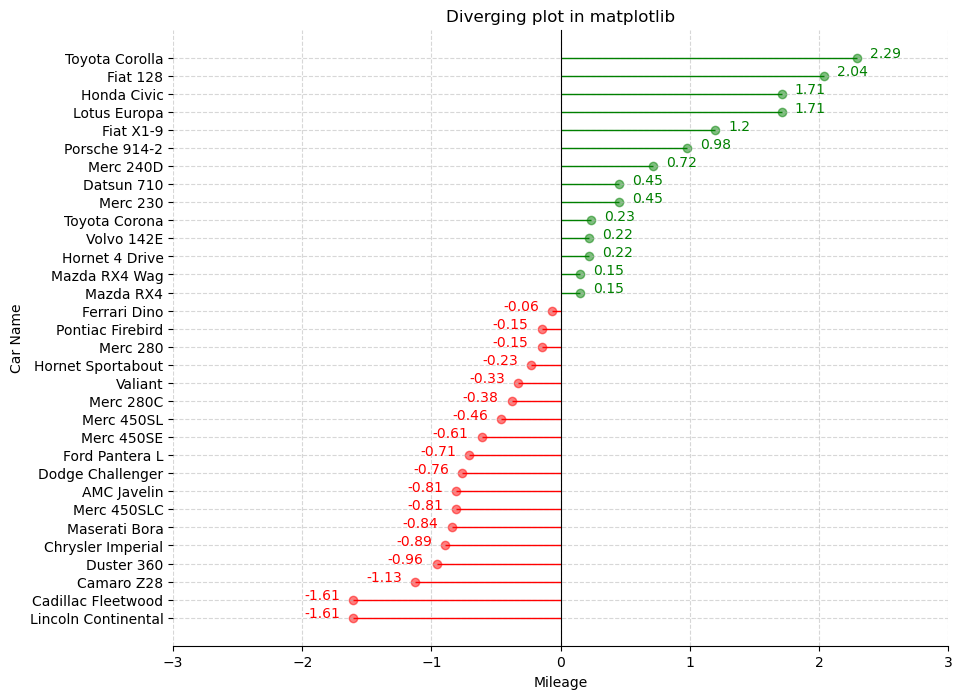

In [26]:
# get the data
PATH = "visual/mtcars.csv"
df = pd.read_csv(PATH)

# More info:
# https://statisticsbyjim.com/glossary/standardization/
df["x_plot"] = (df["mpg"] - df["mpg"].mean())/df["mpg"].std()

# sort value and reset the index
df.sort_values("x_plot", inplace = True)
df.reset_index(inplace=True)

# create a color list, where if value is above > 0 it's green otherwise red
colors = ["red" if x < 0 else "green" for x in df["x_plot"]]


fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot()


ax.hlines(y = df.index, xmin = 0 , color = colors,  xmax = df["x_plot"], linewidth = 1)


# iterate over x and y 
for x, y in zip(df["x_plot"], df.index):
    # annotate text
    ax.text(x - 0.1 if x < 0 else x + 0.1, 
             y, 
             round(x, 2), 
             color = "red" if x < 0 else "green",  
             horizontalalignment='right' if x < 0 else 'left', 
             size = 10)
   
    ax.scatter(x, 
                y, 
                color = "red" if x < 0 else "green", 
                alpha = 0.5)


# set title
ax.set_title("Diverging plot in matplotlib")
# change x lim
ax.set_xlim(-3, 3)

# set labels
ax.set_xlabel("Mileage")
ax.set_ylabel("Car Name")

ax.grid(linestyle='--', alpha=0.5)
ax.set_yticks(df.index)
ax.set_yticklabels(df.model)
ax.spines["top"].set_color("None")
ax.spines["left"].set_color("None")
ax.spines['right'].set_position(('data',0))
ax.spines['right'].set_color('black')

## Gráfico de Puntos Divergentes

- Gráfico de puntos divergentes es útil en el trazado de la varianza.
- Crear Gráfico de puntos divergentes en matplotlib usando el dataset mtcars.csv

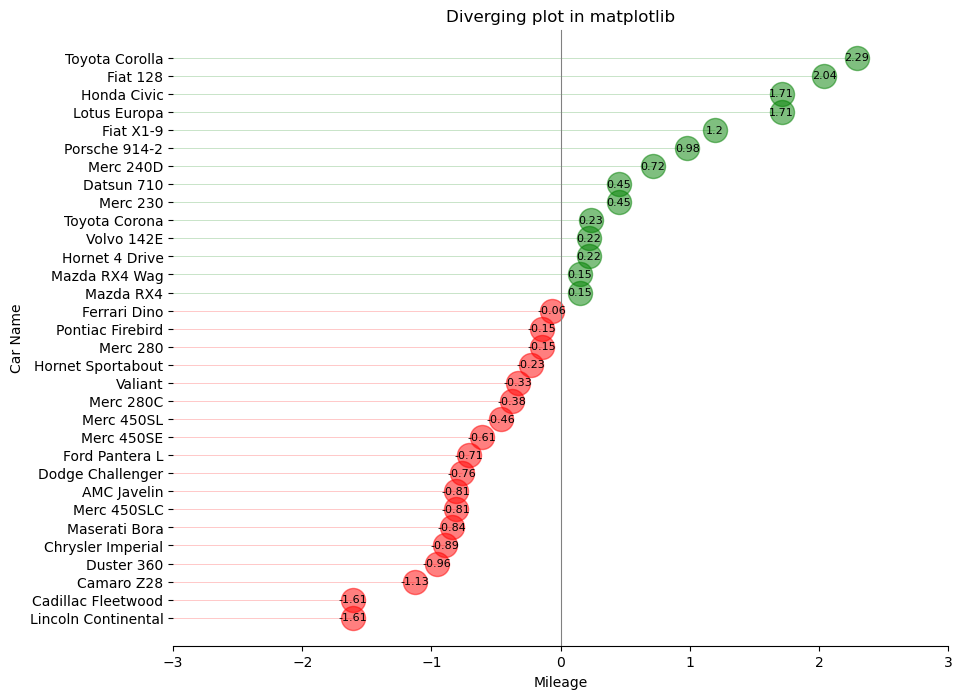

In [28]:
PATH = "visual/mtcars.csv"
df = pd.read_csv(PATH)

# More info:
# https://statisticsbyjim.com/glossary/standardization/
df["x_plot"] = (df["mpg"] - df["mpg"].mean())/df["mpg"].std()

# sort value and reset the index
df.sort_values("x_plot", inplace = True)
df.reset_index(inplace=True)

# create a color list, where if value is above > 0 it's green otherwise red
colors = ["red" if x < 0 else "green" for x in df["x_plot"]]



fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot()


# iterate over x and y and annotate text and plot the data
for x, y in zip(df["x_plot"], df.index):
    
    # make a horizontal line from the y till the x value
    # this doesn't appear in the original 50 plot challenge
    ax.hlines(y = y, 
               xmin = -3,  
               xmax = x, 
               linewidth = 0.5,
               alpha = 0.3,
               color = "red" if x < 0 else "green")
    
    # annotate text
    ax.text(x, 
             y, 
             round(x, 2), 
             color = "black",
             horizontalalignment='center', 
             verticalalignment='center',
             size = 8)
    
    # plot the points
    ax.scatter(x, 
                y, 
                color = "red" if x < 0 else "green", 
                s = 300,
                alpha = 0.5)


# set title
ax.set_title("Diverging plot in matplotlib")

# change x lim
ax.set_xlim(-3, 3)

# set labels
ax.set_xlabel("Mileage")
ax.set_ylabel("Car Name")


ax.set_yticks(df.index)
ax.set_yticklabels(df.model)


ax.spines["top"].set_color("None")
ax.spines["left"].set_color("None")


ax.spines['right'].set_position(('data',0))
ax.spines['right'].set_color('grey')

## Gráfico de Paleta Divergente

- Un gráfico de paleta divergente es una herramienta útil para comparar datos que caen en dos categorías, generalmente indicadas por diferentes colores.
- Crear gráfico de paleta divergente en matplotlib usando el dataset mtcars.csv

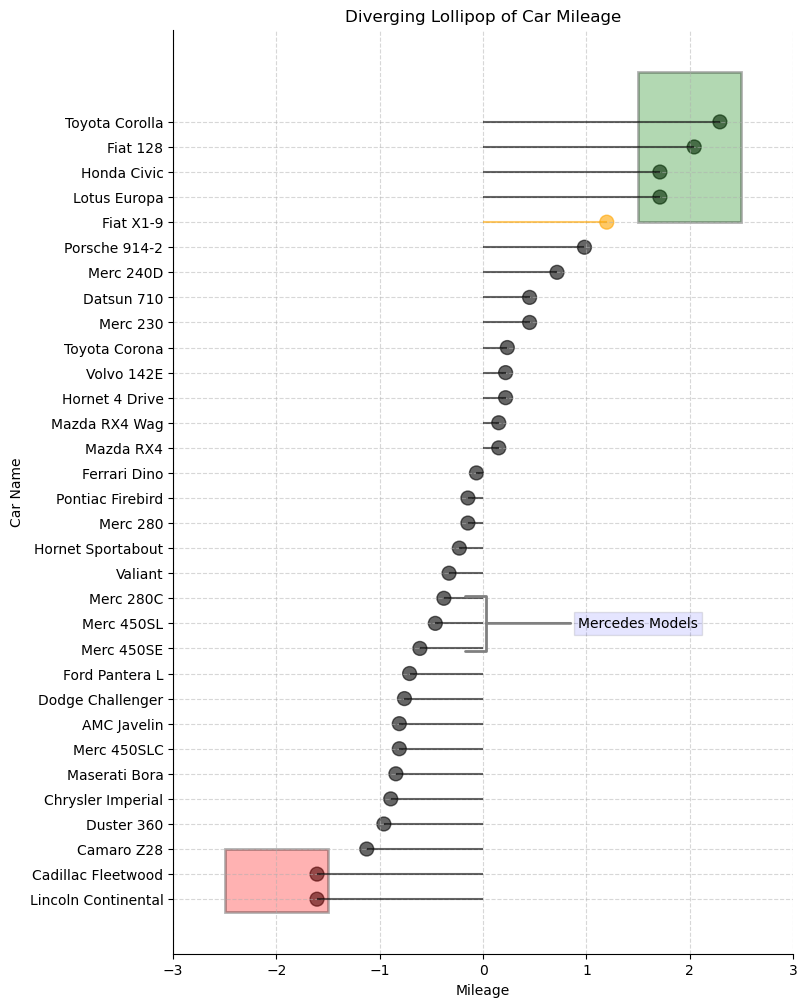

In [30]:
# get the data
PATH = "visual/mtcars.csv"
df = pd.read_csv(PATH)

# More info:
# https://statisticsbyjim.com/glossary/standardization/
df["x_plot"] = (df["mpg"] - df["mpg"].mean())/df["mpg"].std()

# sort value and reset the index
df.sort_values("x_plot", inplace = True)
df.reset_index(inplace = True)


df["color"] = df["model"].apply(lambda car_name: "orange" if car_name == "Fiat X1-9" else "black")



fig = plt.figure(figsize = (8, 12))
ax = fig.add_subplot()


ax.hlines(y = df.index, 
          xmin = 0,
          xmax = df["x_plot"],
          color = df["color"],
          alpha = 0.6)

# plot the dots
ax.scatter(x = df["x_plot"],
          y = df.index,
          s = 100,
          color = df["color"],
          alpha = 0.6)


def add_patch(verts, ax, color):
    '''
    Takes the vertices and the axes as argument and adds the patch to our plot.
    '''
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]

    path = Path(verts, codes)
    pathpatch = PathPatch(path, facecolor = color, lw = 2, alpha = 0.3)
    ax.add_patch(pathpatch)

# coordinates for the bottom shape
verts_bottom = [
   (-2.5, -0.5),  # left, bottom
   (-2.5, 2),  # left, top
   (-1.5, 2),  # right, top
   (-1.5, -0.5),  # right, bottom
   (0., 0.),  # ignored
]

# coordinates for the upper shape
verts_upper = [
   (1.5, 27),  # left, bottom
   (1.5, 33),  # left, top
   (2.5, 33),  # right, top
   (2.5, 27),  # right, bottom
   (0., 0.),  # ignored
]

# use the function to add them to the existing plot
add_patch(verts_bottom, ax, color = "red")
add_patch(verts_upper, ax, color = "green")

# annotate text
ax.annotate('Mercedes Models', 
            xy = (0.0, 11.0), 
            xytext = (1.5, 11), 
            xycoords = 'data', 
            fontsize = 10, 
            ha = 'center', 
            va = 'center',
            bbox = dict(boxstyle = 'square', fc = 'blue', alpha = 0.1),
            arrowprops = dict(arrowstyle = '-[, widthB=2.0, lengthB=1.5', lw = 2.0, color = 'grey'), color = 'black')


# set title
ax.set_title("Diverging Lollipop of Car Mileage")

# autoscale
ax.autoscale_view()

# change x lim
ax.set_xlim(-3, 3)

# set labels
ax.set_xlabel("Mileage")
ax.set_ylabel("Car Name")


ax.set_yticks(df.index)
ax.set_yticklabels(df.model)


ax.spines["right"].set_color("None")
ax.spines["top"].set_color("None")


ax.grid(linestyle='--', alpha=0.5);

## Gráfico Pairplot

- seaborn.pairplot(): Para graficar múltiples distribuciones bivariadas de un conjunto de datos, puede utilizar la función **.pairplot()**. Las diagonales del gráfico son los pares univariados, y esto muestra la relación para la combinación (n, 2) de variables en un DataFrame como una matriz de datos.

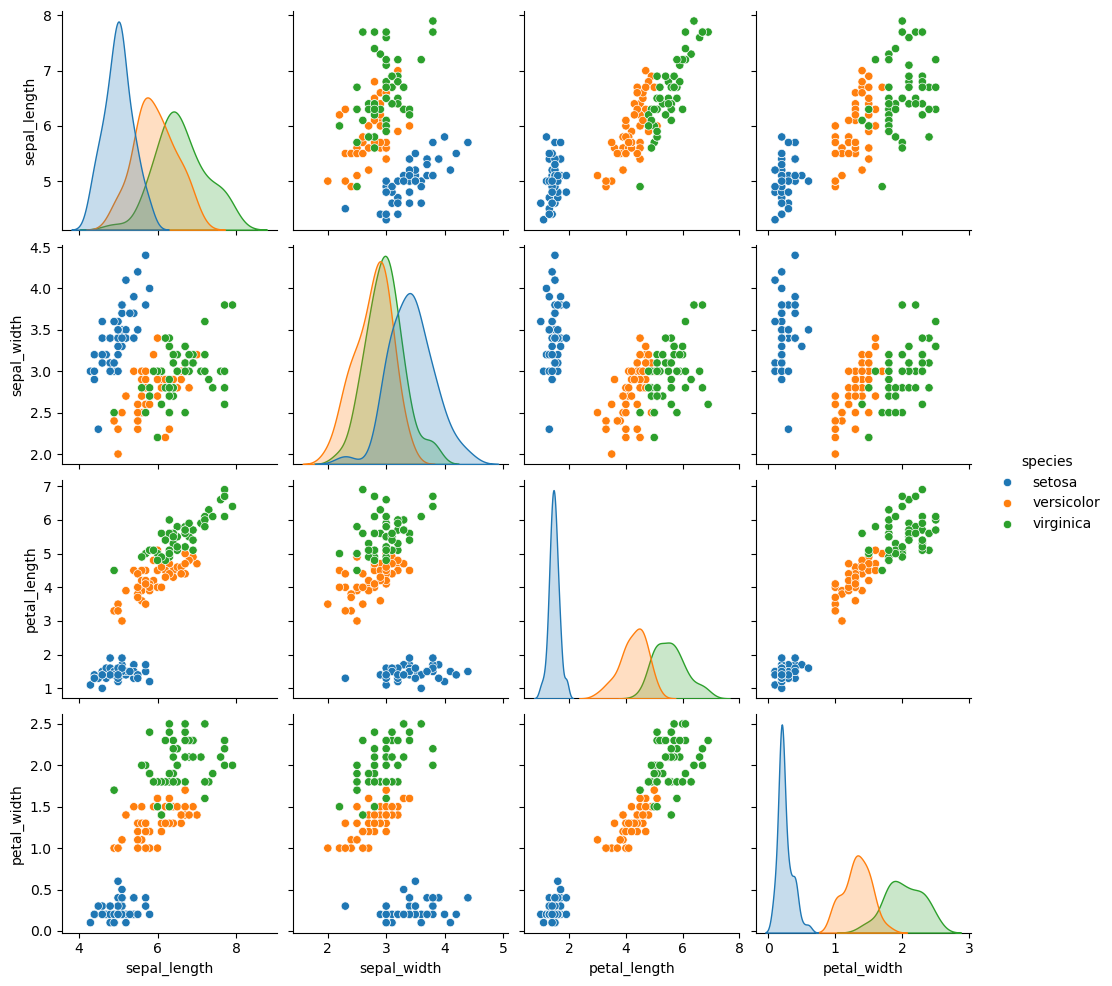

In [52]:
df = sns.load_dataset('iris')

# plot the data using seaborn
sns.pairplot(df, 
             hue = "species" 
            );

## Gráfico de área

- Un gráfico de área es realmente similar a un gráfico de línea, excepto que el área entre el eje x y la línea se llena con color o sombreado. Representa la evolución de una variable numérica.

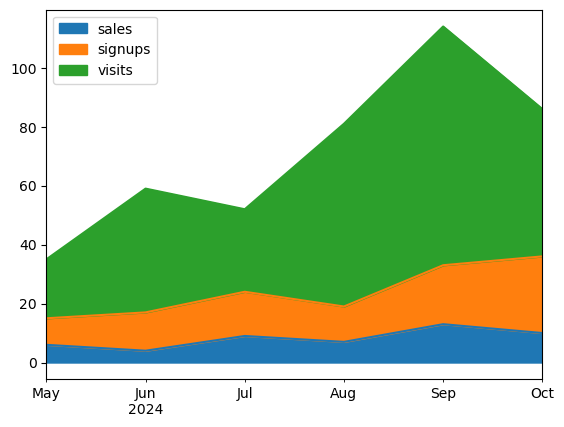

In [34]:
df = pd.DataFrame({
    'sales': [6, 4, 9, 7, 13, 10],
    'signups': [9,13, 15, 12, 20, 26],
    'visits': [20, 42, 28, 62, 81, 50],
}, index=pd.date_range(start='2024/05/01', end='2024/11/01',
                       freq='M'))

ax = df.plot.area()

- Utilizando el conjunto de datos economics.csv para crear un gráfico de área de rendimiento de % de variación mensual (serie temporal)

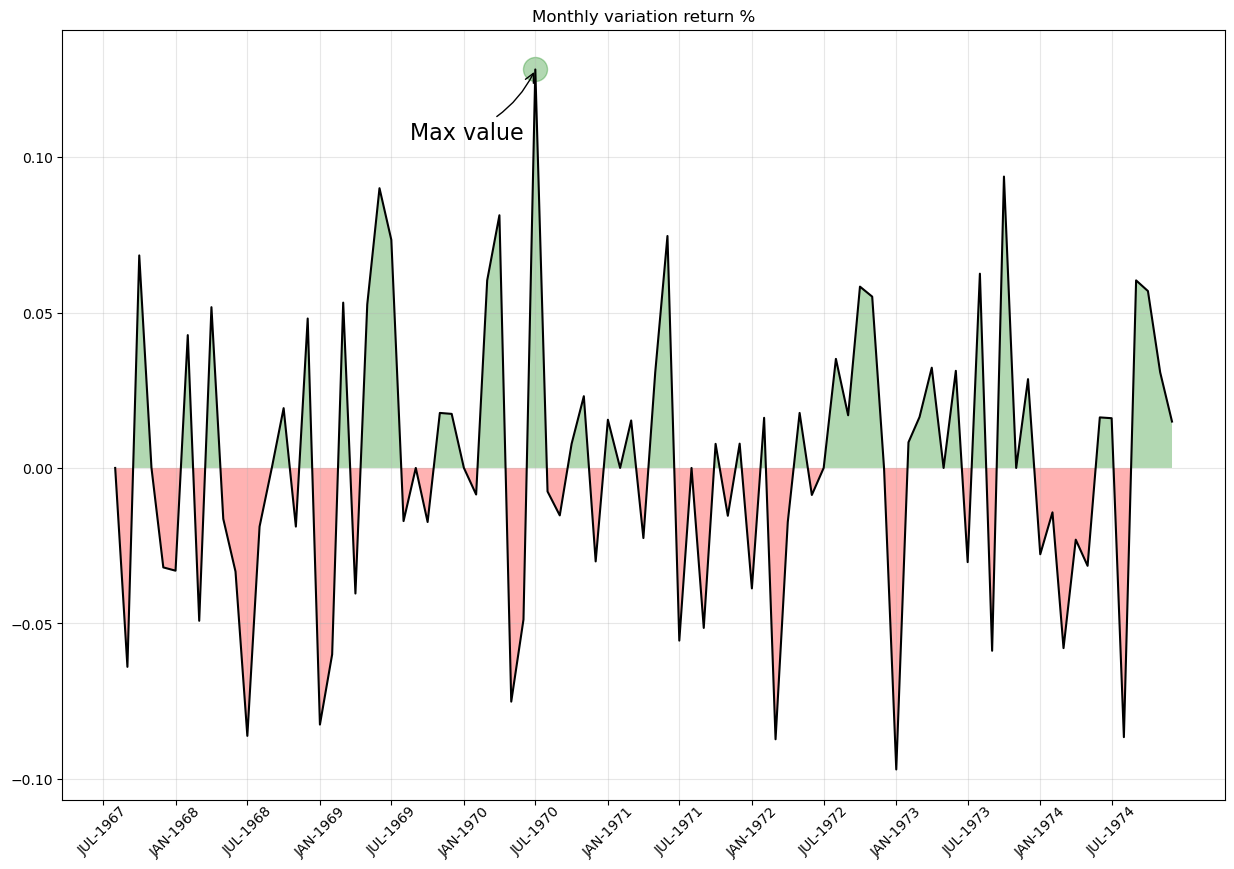

In [36]:
# get the data

PATH = "visual/economics.csv"
df = pd.read_csv(PATH)


df["pce_monthly_change"] = (df["psavert"] - df["psavert"].shift(1))/df["psavert"].shift(1)

# convert todatetime
df["date_converted"] = pd.to_datetime(df["date"])

# filter our df for a specific date
df = df[df["date_converted"] < np.datetime64("1975-01-01")]

# separate x and y 
x = df["date_converted"]
y = df["pce_monthly_change"]

# calculate the max values to annotate on the plot
y_max = y.max()

# find the index of the max value
x_ind = np.where(y == y_max)

# find the x based on the index of max
x_max = x.iloc[x_ind]


fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot()


ax.plot(x, y, color = "black")
ax.scatter(x_max, y_max, s = 300, color = "green", alpha = 0.3)

# annotate the text of the Max value
ax.annotate(r'Max value',
             xy = (x_max, y_max), 
             xytext = (-90, -50), 
             textcoords = 'offset points', 
             fontsize = 16,
             arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=.2")
           )

ax.fill_between(x, 0, y, where = 0 > y, facecolor='red', interpolate = True, alpha = 0.3)
ax.fill_between(x, 0, y, where = 0 <= y, facecolor='green', interpolate = True, alpha = 0.3)


ax.set_ylim(y.min() * 1.1, y.max() * 1.1)


xtickvals = [str(m)[:3].upper() + "-" + str(y) for y,m in zip(df.date_converted.dt.year, df.date_converted.dt.month_name())]

# this way we can set the ticks to be every 6 months.
ax.set_xticks(x[::6])


ax.set_xticklabels(xtickvals[::6], rotation=45, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})

# add a grid
ax.grid(alpha = 0.3)

# set the title
ax.set_title("Monthly variation return %");

## Gráfico de Barras Ordenado

- Se puede ordenar las barras en orden de ascendente/descendente en un gráfico de barras en Matplotlib.
- Crear el gráfico de barras ordenado para mostrar comparaciones entre categorías discretas en el mencionado conjunto de datos mpg.ggplot2.csv

/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/2094102292.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=90)


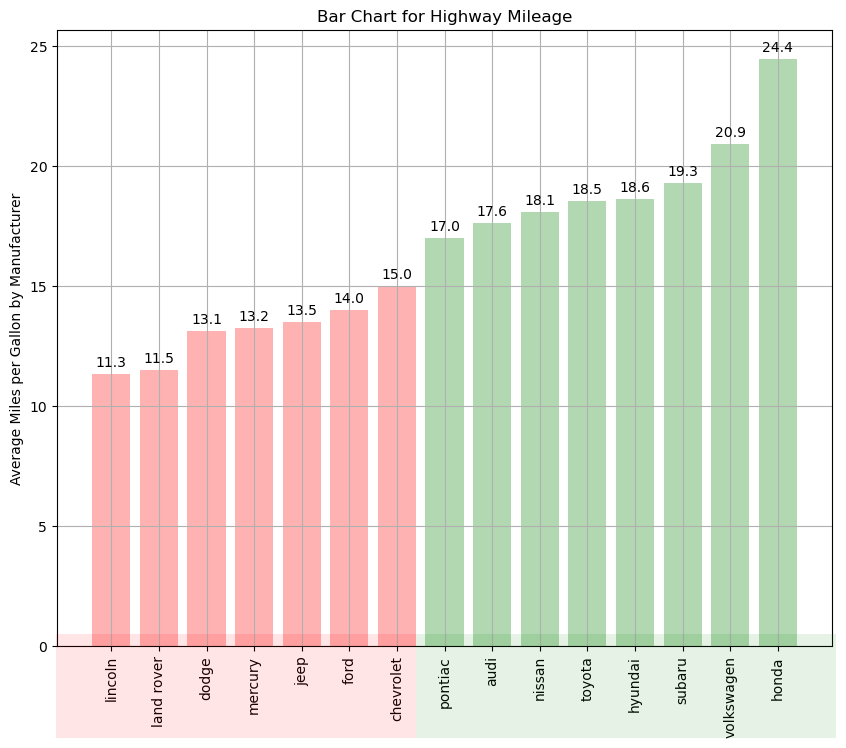

In [38]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


# groupby and create the target x and y
gb_df = df.groupby(["manufacturer"])[["cyl", "displ", "cty"]].mean()
gb_df.sort_values("cty", inplace = True)

x = gb_df.index
y = gb_df["cty"]


fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot()


for x_, y_ in zip(x, y):
    # this is very cool, since we can pass a function to matplotlib
    # and it will plot the color based on the result of the evaluation
    ax.bar(x_, y_, color = "red" if y_ < y.mean() else "green", alpha = 0.3)
    
     # add some text
    ax.text(x_, y_ + 0.3, round(y_, 1), horizontalalignment = 'center')



p2 = patches.Rectangle((.124, -0.005), width = .360, height = .13, alpha = .1, facecolor = 'red', transform = fig.transFigure)
fig.add_artist(p2)

# green one
p1 = patches.Rectangle((.124 + .360, -0.005), width = .42, height = .13, alpha = .1, facecolor = 'green', transform = fig.transFigure)
fig.add_artist(p1)

# rotate the x ticks 90 degrees
ax.set_xticklabels(x, rotation=90)

# add an y label
ax.set_ylabel("Average Miles per Gallon by Manufacturer")

# set a title
ax.set_title("Bar Chart for Highway Mileage");
plt.grid()

## Gráfico de Paleta (Lollipop Chart)

- Lollipop Charts no es más que una variación del gráfico de barras en el que la barra gruesa se reemplaza con sólo una línea y un punto similar a la "o" al final.

/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/3042953914.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation = 90)


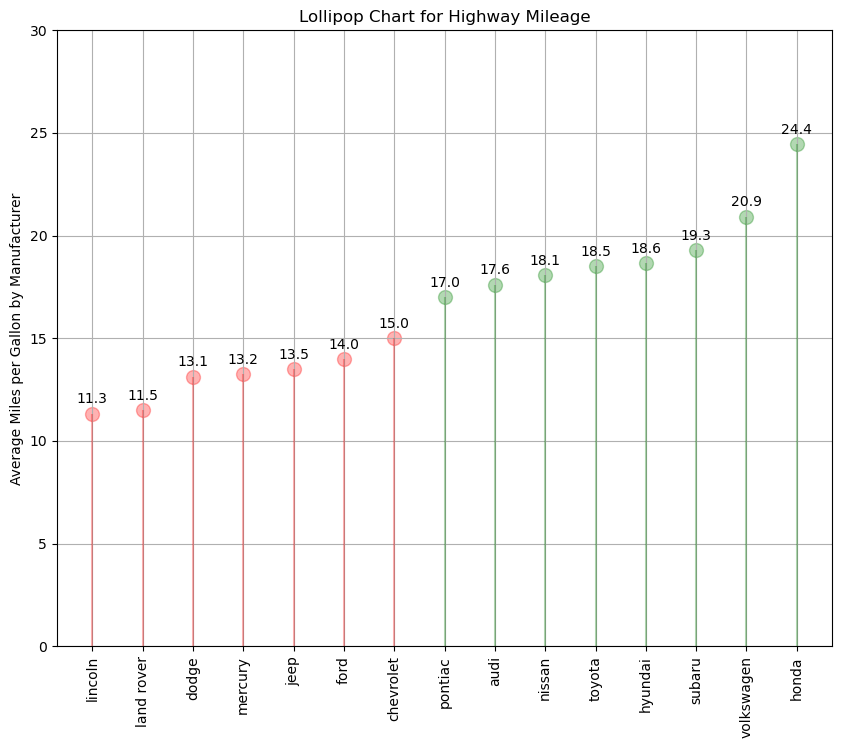

In [40]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


gb_df = df.groupby(["manufacturer"])[["cyl", "displ", "cty"]].mean()
gb_df.sort_values("cty", inplace = True)

x = gb_df.index
y = gb_df["cty"]


fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot()


for x_, y_ in zip(x, y):
    # make a scatter plot
    ax.scatter(x_, y_, color = "red" if y_ < y.mean() else "green", alpha = 0.3, s = 100)
    
    
    ax.vlines(x_, ymin = 0, ymax = y_, color = "red" if y_ < y.mean() else "green", alpha = 0.3)
    
    # add text with the data
    ax.text(x_, y_ + 0.5, round(y_, 1), horizontalalignment='center')
    

ax.set_ylim(0, 30)


ax.set_xticklabels(x, rotation = 90)


ax.set_ylabel("Average Miles per Gallon by Manufacturer")

# set a title
ax.set_title("Lollipop Chart for Highway Mileage");
plt.grid()

## Gráfico de puntos

- Un gráfico de puntos transmite orden de rango de los elementos. Este es un gráfico simple que utiliza círculos sólidos, o puntos, para mostrar la frecuencia de cada valor de datos único.

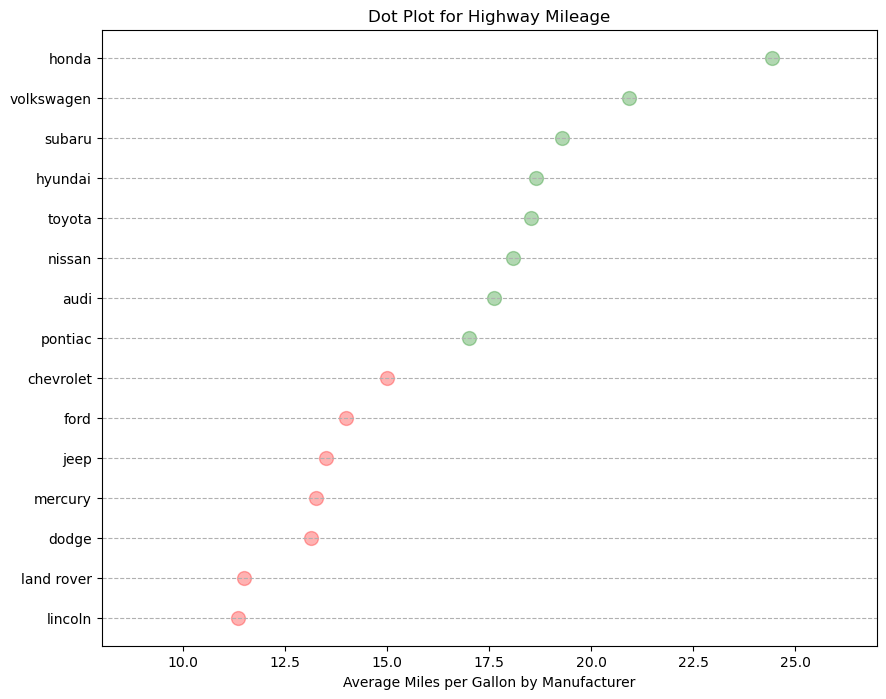

In [42]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


gb_df = df.groupby(["manufacturer"])[["cyl", "displ", "cty"]].mean()
gb_df.sort_values("cty", inplace = True)

x = gb_df.index
y = gb_df["cty"]


fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot()


for x_, y_ in zip(x, y):
    ax.scatter(y_, x_, color = "red" if y_ < y.mean() else "green", alpha = 0.3, s = 100)
    

ax.set_xlim(8, 27)


ax.set_xlabel("Average Miles per Gallon by Manufacturer")

# set the title
ax.set_title("Dot Plot for Highway Mileage")


ax.grid(which = 'major', axis = 'y', linestyle = '--');

## Gráfico de pendiente

- Una gráfico de pendiente es una representación utilizada para mostrar cambios en los valores entre dos o más puntos o categorías de datos.
- Crear gráfico de pendiente usando el dataset gdppercap.csv

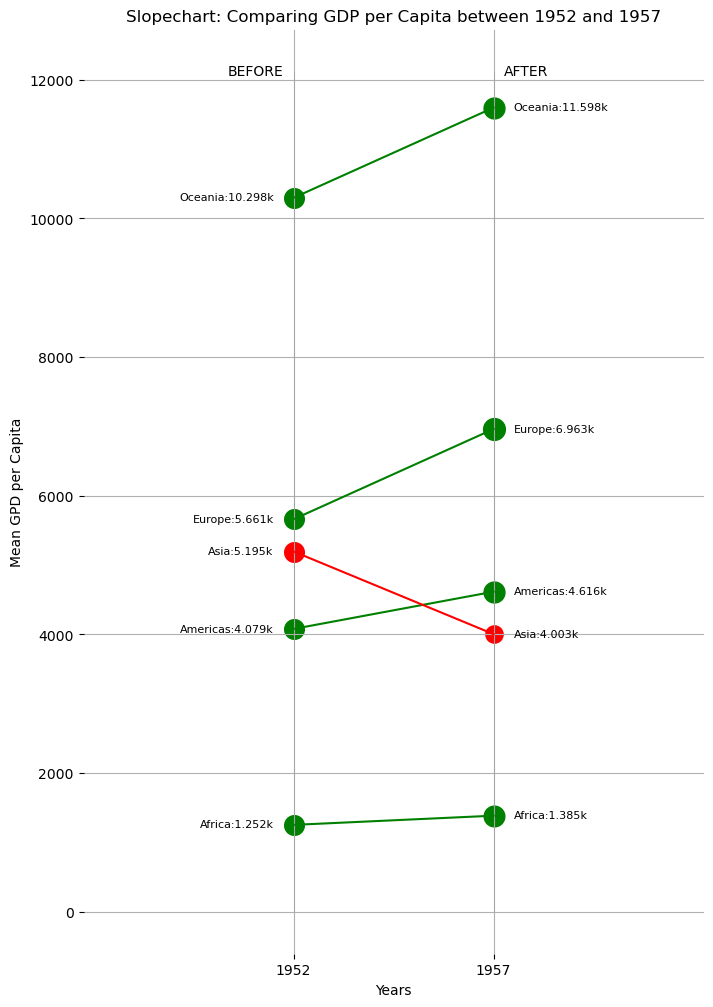

In [44]:
# get the data
PATH  = 'visual/gdppercap.csv'
df = pd.read_csv(PATH)


df["color"] = df.apply(lambda row: "green" if row["1957"] >= row["1952"] else "red", axis = 1)


fig = plt.figure(figsize = (8, 12))
ax = fig.add_subplot()


for cont in df["continent"]:
    
    # prepare the data for plotting
    # extract each point and the color
    x_start = df.columns[1]
    x_finish = df.columns[2]
    y_start = df[df["continent"] == cont]["1952"]
    y_finish = df[df["continent"] == cont]["1957"]
    color = df[df["continent"] == cont]["color"]
    
    
    ax.scatter(x_start, y_start, color = color, s = 200)
    ax.scatter(x_finish, y_finish, color = color, s = 200*(y_finish/y_start))
    
    
    ax.plot([x_start, x_finish], [float(y_start), float(y_finish)], linestyle = "-", color = color.values[0])
    
    # annotate the value for each continent
    ax.text(ax.get_xlim()[0] - 0.05, y_start, r'{}:{}k'.format(cont, int(y_start)/1000), horizontalalignment = 'right', verticalalignment = 'center', fontdict = {'size':8})
    ax.text(ax.get_xlim()[1] + 0.05, y_finish, r'{}:{}k'.format(cont, int(y_finish)/1000), horizontalalignment = 'left', verticalalignment = 'center', fontdict = {'size':8})


x_lims = ax.get_xlim()
y_lims = ax.get_ylim()


ax.set_xlim(x_lims[0] - 1, x_lims[1] + 1);

# add 2 vertical lines
ax.vlines(x_start, 0, y_lims[1], color = "grey", alpha = 0.3, lw = 0.5)
ax.vlines(x_finish, 0, y_lims[1], color = "grey", alpha = 0.3, lw = 0.5)


ax.text(x_lims[0], y_lims[1], "BEFORE", horizontalalignment = 'right', verticalalignment = 'center')
ax.text(x_lims[1], y_lims[1], "AFTER", horizontalalignment = 'left', verticalalignment = 'center')

# set and x and y label
ax.set_xlabel("Years")
ax.set_ylabel("Mean GPD per Capita")

# add a title
ax.set_title("Slopechart: Comparing GDP per Capita between 1952 and 1957")


ax.spines["left"].set_color("None")
ax.spines["right"].set_color("None")
ax.spines["top"].set_color("None")
ax.spines["bottom"].set_color("None")
plt.grid()

# More info: 
# https://datavizproject.com/data-type/slope-chart/

## Gráfico Dumbbell

- El gráfico Dumbbell (también conocida como gráfico de punto conectado) es ideal para mostrar cambios entre dos puntos en el tiempo, dos condiciones o diferencias entre dos grupos.

/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/4205793914.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["{:.0f}%".format(round(tick*100, 0)) for tick in x_ticks]);


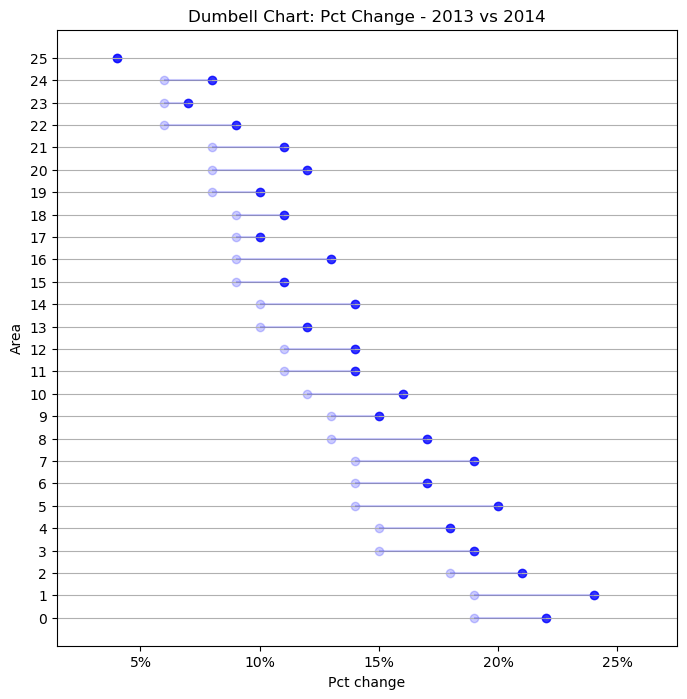

In [46]:
# get the data
PATH = "visual/health.csv"
df = pd.read_csv(PATH)


fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()


for i, area in zip(df.index, df["Area"]):
    
  
    start_data = df[df["Area"] == area]["pct_2013"].values[0]
    finish_data = df[df["Area"] == area]["pct_2014"].values[0]
    
  
    ax.scatter(start_data, i, c = "blue", alpha = .8)
    ax.scatter(finish_data, i, c = "blue", alpha = .2)
    
   
    ax.hlines(i, start_data, finish_data, color = "blue", alpha = .2)
    

# set x and y label
ax.set_xlabel("Pct change")
ax.set_ylabel("Area")

# set the title
ax.set_title("Dumbell Chart: Pct Change - 2013 vs 2014")


ax.grid(axis = "x")


x_lim = ax.get_xlim()
ax.set_xlim(x_lim[0]*.5, x_lim[1]*1.1)


x_ticks = ax.get_xticks()
ax.set_xticklabels(["{:.0f}%".format(round(tick*100, 0)) for tick in x_ticks]);

ax.set_yticks(df.index)

plt.grid()

# More info: 
# https://www.amcharts.com/demos/dumbbell-plot/

## Histograma Apilado de Variables Continuas

- El histograma es una de las herramientas gráficas más útiles para comprender la distribución de una variable continua.
- Un histograma apilado de dos o más variables mostrados en la misma escala se utiliza para comparar variables.

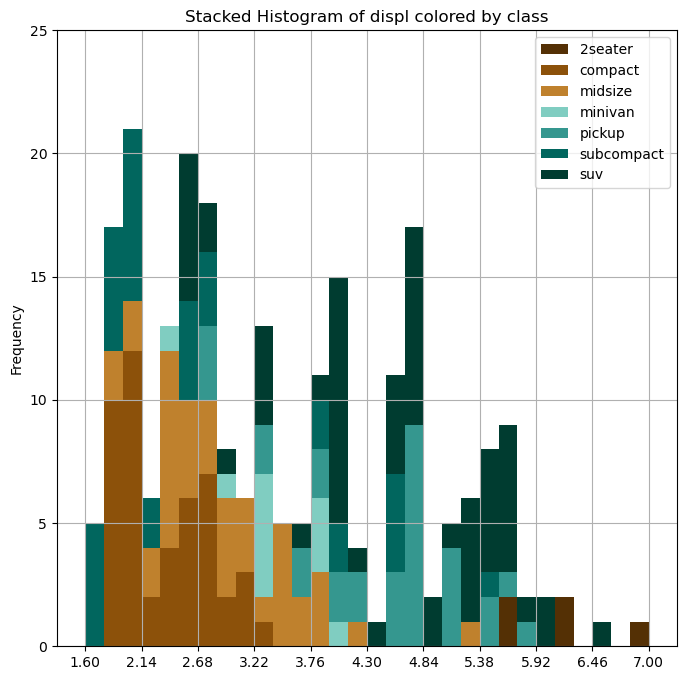

In [48]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


gb_df = df[["class", "displ"]].groupby("class")
lx = []
ln = []


colors = ["#543005", "#8c510a", "#bf812d", "#80cdc1", "#35978f", "#01665e", "#003c30"]


for _, df_ in gb_df:
    lx.append(df_["displ"].values.tolist())
    ln.append(list(set(df_["class"].values.tolist()))[0])


fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()


n, bins, patches = ax.hist(lx, bins = 30, stacked = True, density = False, color = colors)


# change x lim
ax.set_ylim(0, 25)
# set the xticks to reflect every third value
ax.set_xticks(bins[::3])

# set a title
ax.set_title("Stacked Histogram of displ colored by class")


ax.legend({class_:color for class_, color in zip(ln, colors)})

# set the y label
ax.set_ylabel("Frequency");
plt.grid()

## Histogramas Apilado de la Variables Categoricas

- El histograma apilado de variables categóricas compara las distribuciones de frecuencia de variables como una trama de barra apliladas y agrupadas.

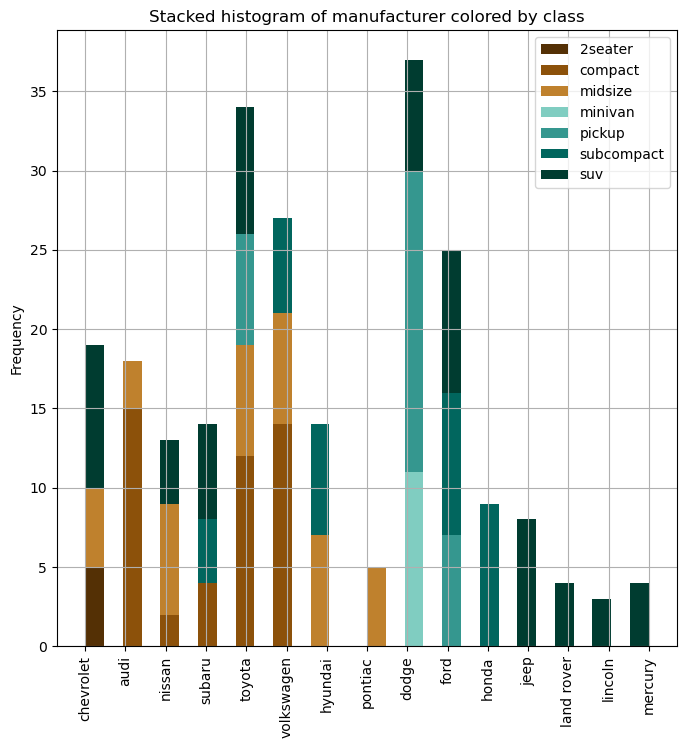

In [50]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


gb_df = df[["class", "manufacturer"]].groupby("class")
lx = []
ln = []


colors = ["#543005", "#8c510a", "#bf812d", "#80cdc1", "#35978f", "#01665e", "#003c30"]


for _, df_ in gb_df:
    lx.append(df_["manufacturer"].values.tolist())
    ln.append(list(set(df_["class"].values.tolist()))[0])


fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()


n, bins, patches = ax.hist(lx, bins = 30, stacked = True, density = False, color = colors)


ax.tick_params(axis = 'x', labelrotation = 90)


ax.legend({class_:color for class_, color in zip(ln, colors)})

# add a title
ax.set_title("Stacked histogram of manufacturer colored by class")

# set an y label
ax.set_ylabel("Frequency");
plt.grid()

## Gráfico de Densidad

- Una gráfico de densidad es una representación de la distribución de una variable numérica. Utiliza una estimación de densidad del núcleo para mostrar la función de probabilidad de densidad de una variable.

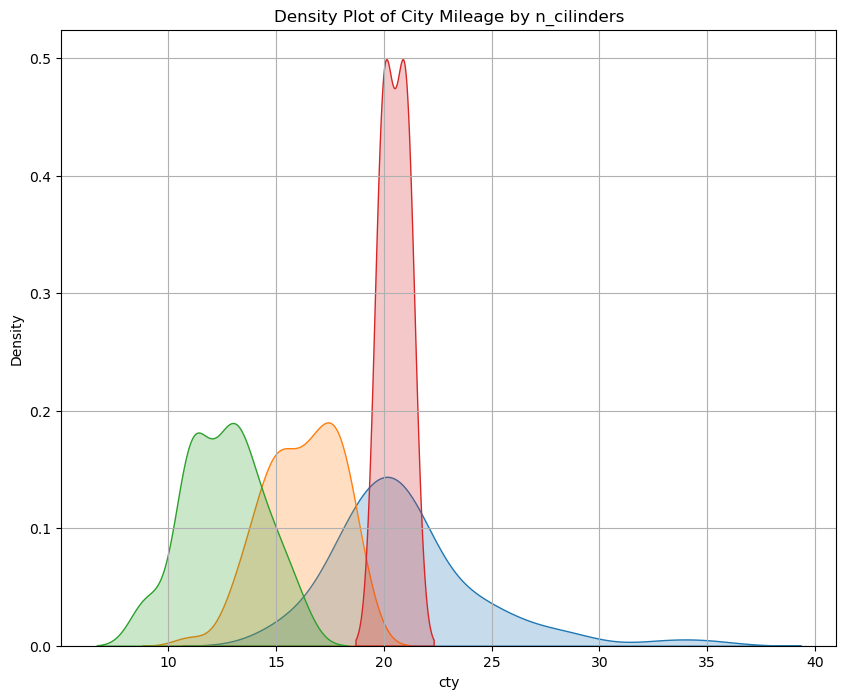

In [52]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


fig = plt.figure(figsize = (10, 8))


for cyl_ in df["cyl"].unique():
    # extract the data
    x = df[df["cyl"] == cyl_]["cty"]
    # plot the data using seaborn
    sns.kdeplot(x, fill=True, label = "{} cyl".format(cyl_))

# set the title of the plot
plt.title("Density Plot of City Mileage by n_cilinders");
plt.grid()

# More info: 
# https://www.data-to-viz.com/graph/density.html

## Gráfico de densidad & histogramas

- Se puede añadir una curva de densidad a un histograma creando el histograma con una escala de densidad, creando los datos de la curva en un marco de datos separado, y añadiendo la curva como otra capa.

/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_768/3832857628.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, kde = True, label = "{} class".format(class_))
/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_768/3832857628.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.d

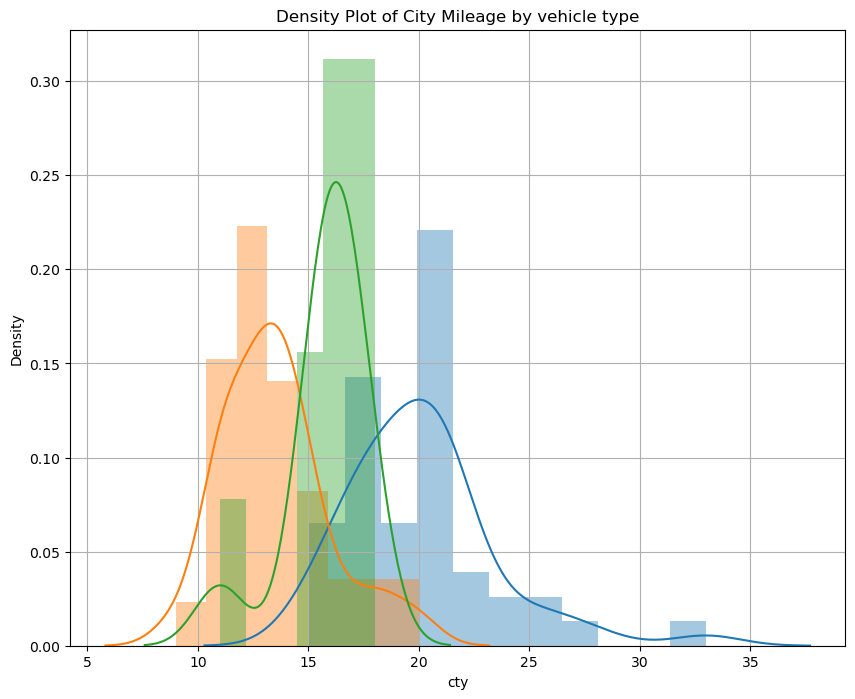

In [14]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


fig = plt.figure(figsize = (10, 8))


for class_ in ["compact", "suv", "minivan"]:
    # extract the data
    x = df[df["class"] == class_]["cty"]
    # plot the data using seaborn
    sns.distplot(x, kde = True, label = "{} class".format(class_))
    
# set the title of the plot
plt.title("Density Plot of City Mileage by vehicle type");
plt.grid()

# More info: 
# https://www.data-to-viz.com/graph/density.html

## Joyplot

- Los Joyplot están apilados, gráficos de densidad parcialmente superpuestas. El código para JoyPy toma prestado del código para KDEs en pandas.plotting, y utiliza un par de funciones.

<Figure size 1120x800 with 0 Axes>

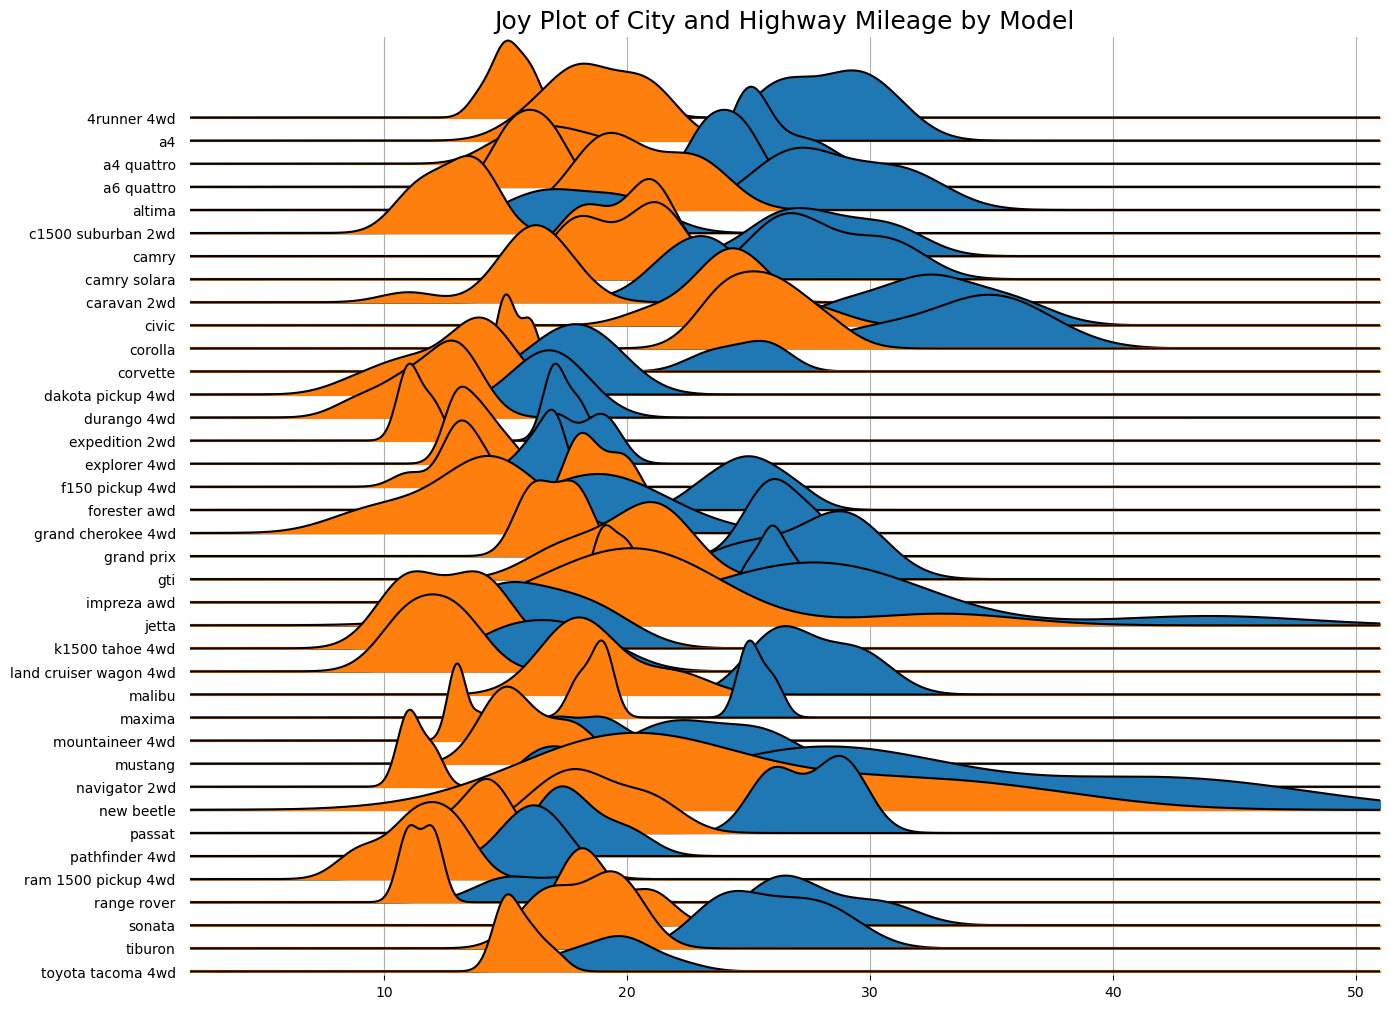

In [16]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)

plt.figure(figsize = (14,10), dpi = 80)
# plot the data using joypy
fig, axes = joypy.joyplot(df, 
                          column = ['hwy', 'cty'], # colums to be plotted.
                          by = "model", # separate the data by this value. Creates a separate distribution for each one.
                          ylim = 'own', 
                          figsize = (14,10)
                         )
# add a title
plt.title('Joy Plot of City and Highway Mileage by Model', fontsize = 18);
plt.grid()
plt.show()

## Gráfico Distribuido de Puntos

- Un gráfico distribuido de puntos visualiza la distribución de datos en múltiples categorías trazando puntos a lo largo de un eje. Cada punto puede representar un único punto de datos o un conteo.

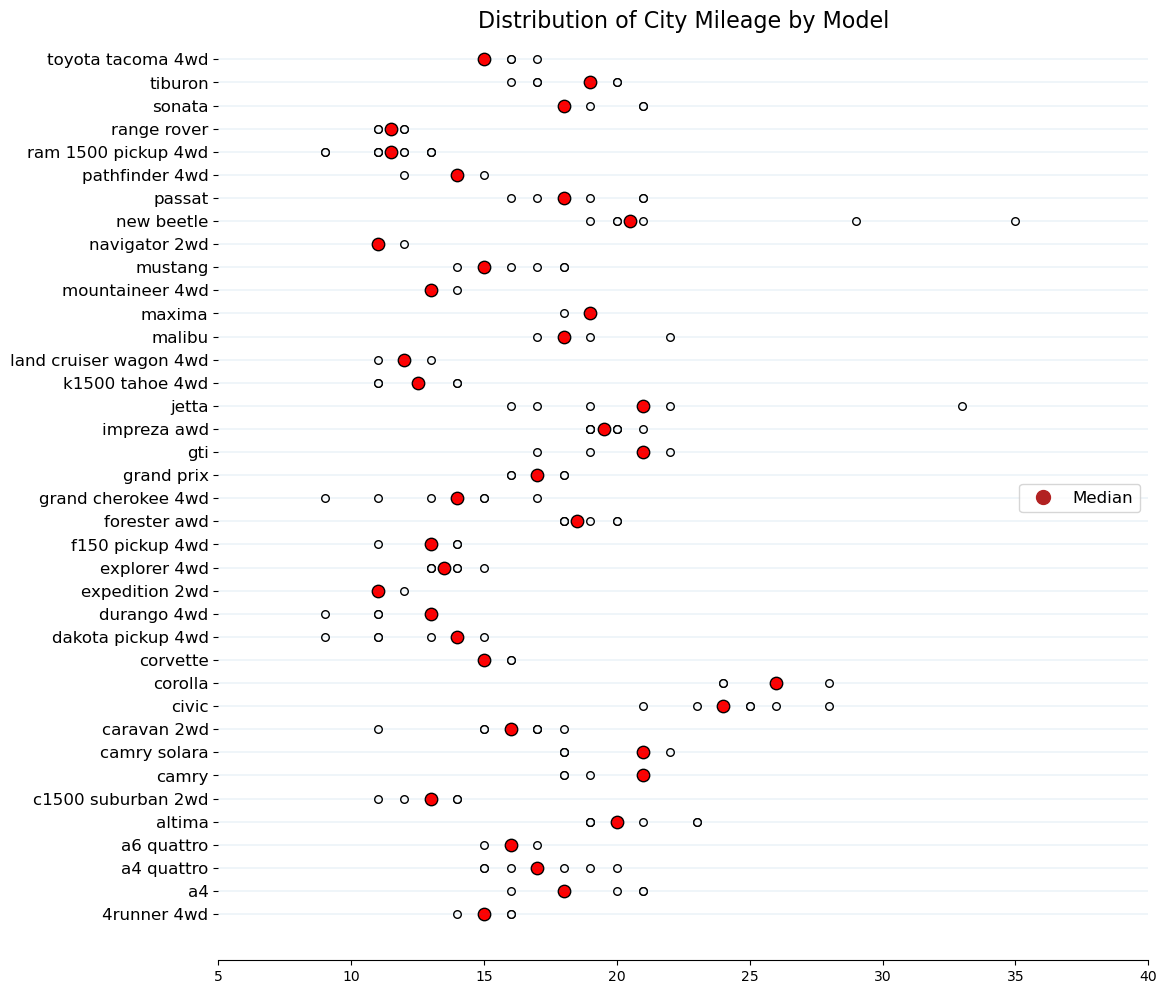

In [54]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)
# sort the values
df.sort_values(["model", "cty"], inplace = True)
lc = []


fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot()

# iterate over each car manufacturer
for i, car in enumerate(df["model"].unique()):
    # prepare the data for plotting
    # get x and y
    x = df[df["model"] == car]["cty"]
    y = [car for i_ in range(len(x))]
    
    # calculate the median value
    x_median = np.median(x)
    
    # plot the data
    ax.scatter(x, y, c = "white", edgecolor = "black", s = 30)
    ax.scatter(x_median, i, c = "red",  edgecolor = "black", s = 80)
    
   
    ax.hlines(i, 0, 40, linewidth = .1)
    
    
    lc.append(car)



ax.set_xlim(5, 40)
ax.set_ylim(-2, 38)


ax.tick_params(axis = "y", labelsize = 12)

# set a title
ax.set_title("Distribution of City Mileage by Model", fontsize = 16)


red_patch = plt.plot([],[], marker = "o", ms = 10, ls = "", mec = None, color = 'firebrick', label = "Median")


plt.legend(handles = red_patch, loc = 7, fontsize = 12)


ax.spines["right"].set_color("None")
ax.spines["left"].set_color("None")
ax.spines["top"].set_color("None");

# More info: 
# https://www.statisticshowto.com/what-is-a-dot-plot/

## Boxplot

- Un boxplot es una forma estandarizada de mostrar el rango intercuartílico (IQR) de un conjunto de datos basado en un resumen de cinco puntos: el minimo, primer cuartil, mediana, tercer cuartil y máximo.
- Los boxplots se utilizan para mostrar distribuciones de valores numéricos de datos, especialmente cuando se quiere comparar entre múltiples grupos.

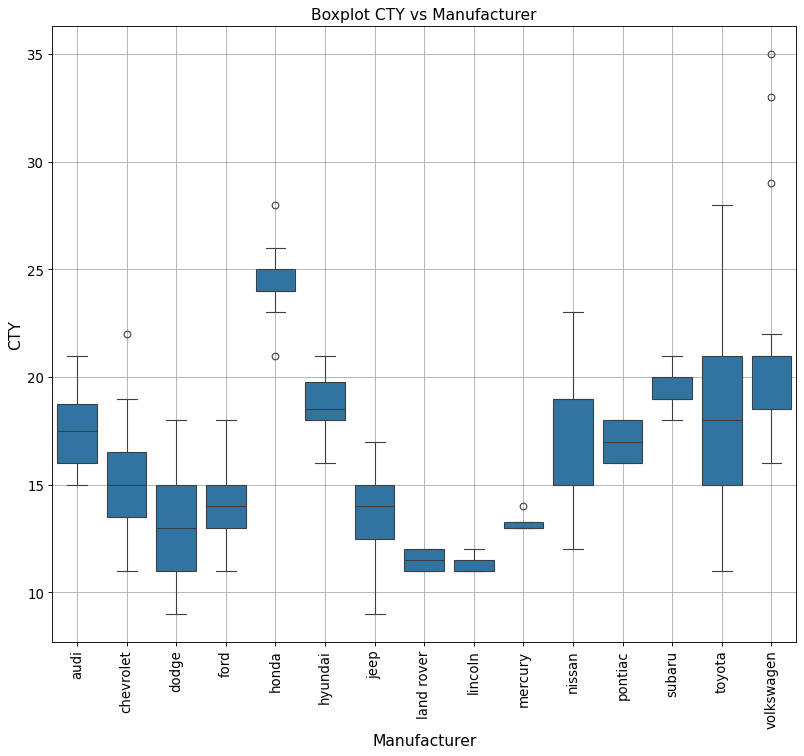

In [60]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


plt.figure(figsize = (12, 10), dpi = 80)

ax = sns.boxplot(x = "manufacturer", y = "cty", data = df)



ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# set and x and y label
ax.set_xlabel("Manufacturer", fontsize = 14)
ax.set_ylabel("CTY", fontsize = 14)

# set a title
ax.set_title("Boxplot CTY vs Manufacturer", fontsize = 14);
plt.grid()

# More info: 
# https://en.wikipedia.org/wiki/Box_plot

## Boxplot & puntos

- El gráfico boxplt y puntos transmite información similar a una división de boxplot en grupos.

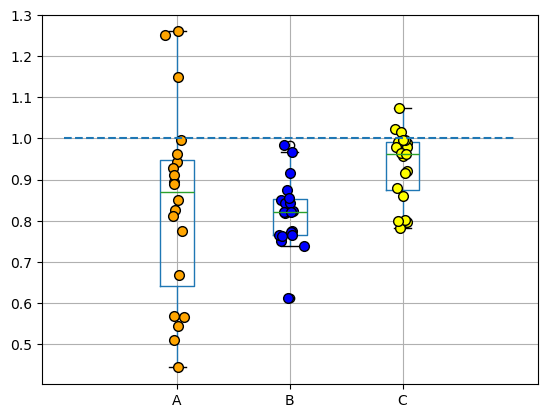

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.DataFrame({ "A":np.random.normal(0.8,0.2,20),
                      "B":np.random.normal(0.8,0.1,20), 
                      "C":np.random.normal(0.9,0.1,20)} )

data.boxplot()

for i,d in enumerate(data):
    y = data[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = ["orange","blue","yellow"][i], mec='k', ms=7, marker="o", linestyle="None")

plt.hlines(1,0,4,linestyle="--")

- Creación de la parcela de boxplot y puntos para CTY vs Clase para cyl = 4, 5, 6, 8

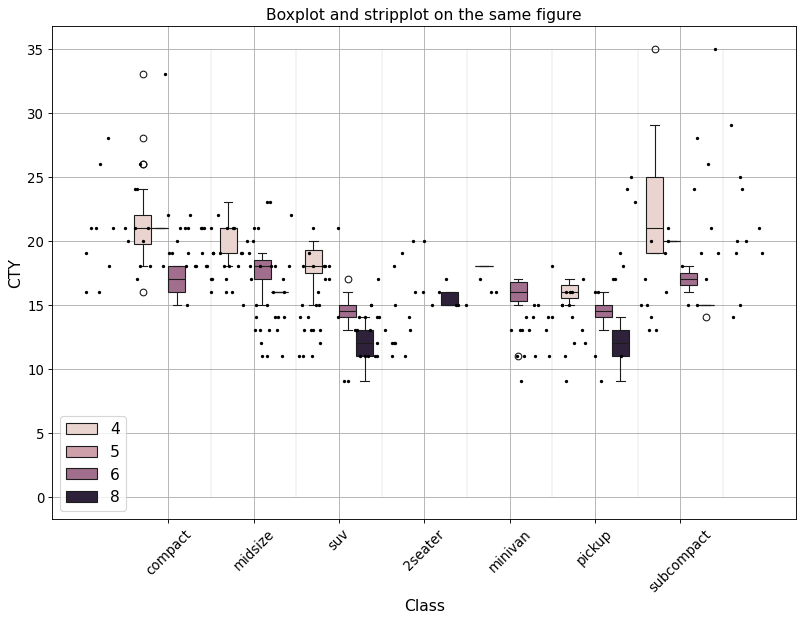

In [64]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


plt.figure(figsize = (12, 8), dpi= 80)
# plot the data using seaborn
# since we don't create a specific separete plot
# everything will be rendered on the same axes
sns.boxplot(x = "class", y = "cty", data = df, hue = "cyl")
sns.stripplot(x = 'class', y = 'cty', data = df, color = 'black', size = 3, jitter = 1)


ax = plt.gca()
# get the xticks to iterate over
xticks = ax.get_xticks()


for tick in xticks:
    ax.vlines(tick + 0.5, 0, np.max(df["cty"]), color = "grey", alpha = .1)

# rotate the x and y ticks
ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# add x and y label
ax.set_xlabel("Class", fontsize = 14)
ax.set_ylabel("CTY", fontsize = 14)

# add a title and put the legend on a specific location
ax.set_title("Boxplot and stripplot on the same figure", fontsize = 14)
ax.legend(loc = "lower left", fontsize = 14);
plt.grid()

# More info: 
# https://en.wikipedia.org/wiki/Box_plot
# https://en.wikipedia.org/wiki/Dot_plot_(statistics)

## Gráfico de violín

- Un gráfico de violín representa distribuciones de datos numéricos para uno o más grupos usando curvas de densidad. La anchura de cada curva se corresponde con la frecuencia aproximada de puntos de datos en cada región.

/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/3457222024.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x = "manufacturer",


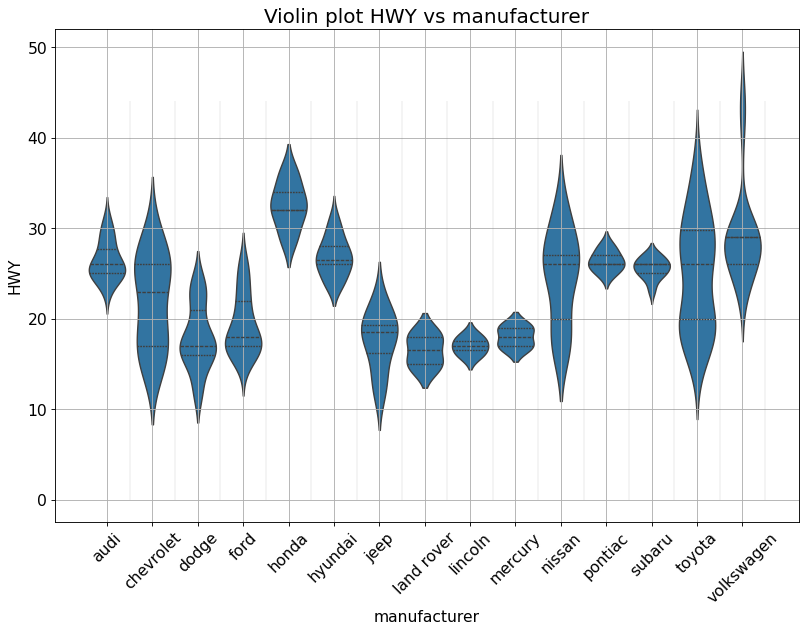

In [66]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


plt.figure(figsize = (12, 8), dpi= 80)
sns.violinplot(x = "manufacturer", 
               y = "hwy", 
               data = df, 
               scale = 'width', 
               inner = 'quartile'
              )


ax = plt.gca()
# get the xticks to iterate over
xticks = ax.get_xticks()


for tick in xticks:
    ax.vlines(tick + 0.5, 0, np.max(df["hwy"]), color = "grey", alpha = .1)
    
# rotate the x and y ticks
ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)

# add x and y label
ax.set_xlabel("manufacturer", fontsize = 14)
ax.set_ylabel("HWY", fontsize = 14)

# set title
ax.set_title("Violin plot HWY vs manufacturer", fontsize = 18);
plt.grid()

# More info: 
# https://en.wikipedia.org/wiki/Violin_plot

## Pirámide de población

- Las pirámides de población son representación gráfica de la estructura edad-sexo de un país o de un área.

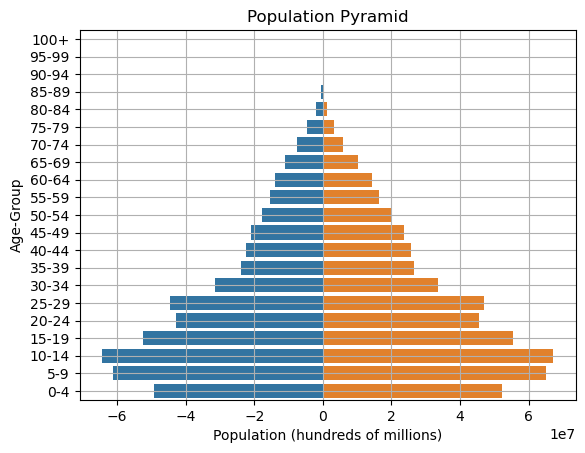

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.DataFrame({'Age': ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+'], 
                    'Male': [-49228000, -61283000, -64391000, -52437000, -42955000, -44667000, -31570000, -23887000, -22390000, -20971000, -17685000, -15450000, -13932000, -11020000, -7611000, -4653000, -1952000, -625000, -116000, -14000, -1000], 
                    'Female': [52367000, 64959000, 67161000, 55388000, 45448000, 47129000, 33436000, 26710000, 25627000, 23612000, 20075000, 16368000, 14220000, 10125000, 5984000, 3131000, 1151000, 312000, 49000, 4000, 0]})


AgeClass = ['100+','95-99','90-94','85-89','80-84','75-79','70-74','65-69','60-64','55-59','50-54','45-49','40-44','35-39','30-34','25-29','20-24','15-19','10-14','5-9','0-4']

bar_plot = sns.barplot(x='Male', y='Age', data=df, order=AgeClass)

bar_plot = sns.barplot(x='Female', y='Age', data=df, order=AgeClass)

bar_plot.set(xlabel="Population (hundreds of millions)", ylabel="Age-Group", title = "Population Pyramid")
plt.grid()

## Gráfico categórico

- Si una de las variables principales es "categorica" (dividida en grupos discretos) puede ser útil utilizar un enfoque más especializado de la visualización.
- En seaborn, catplot() da un acceso de mayor nivel a un número de funciones de nivel de ejes para trazar datos categóricos de diferentes maneras.

<Figure size 1200x600 with 0 Axes>

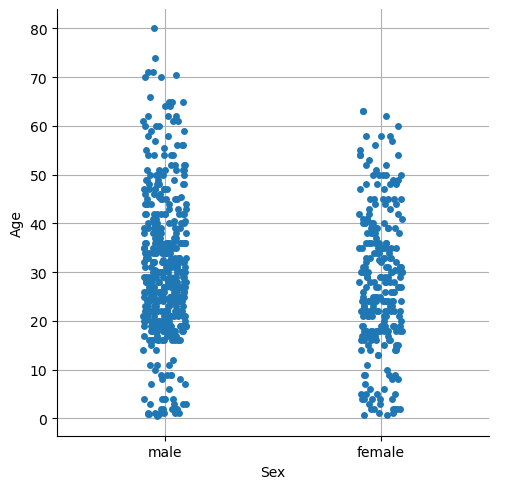

In [70]:
# get the data
PATH = "visual/train.csv"
df = pd.read_csv(PATH)


#https://www.geeksforgeeks.org/python-seaborn-catplot/
fig = plt.figure(figsize = (12, 6))


ax = sns.catplot(x="Sex", y="Age", 
                data=df)
plt.grid()

# More info: 
# https://seaborn.pydata.org/tutorial/categorical.html

## Gráfico Waffle

- Un gráfico Waffle es una técnica de visualización apasionante que normalmente se crea para mostrar progreso hacia metas.

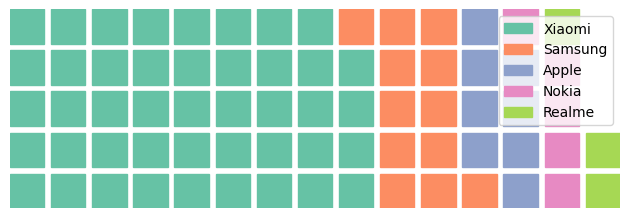

In [72]:
# importing all necessary requirements 
import pandas as pd 
import matplotlib.pyplot as plt 
from pywaffle import Waffle 
  
# creation of a dataframe 
data ={'phone': ['Xiaomi', 'Samsung', 
                 'Apple', 'Nokia', 'Realme'], 
       'stock': [44, 12, 8, 5, 3] 
     } 
  
df = pd.DataFrame(data) 
  
# To plot the waffle Chart 
fig = plt.figure( 
    FigureClass = Waffle, 
    rows = 5, 
    values = df.stock, 
    labels = list(df.phone) 
) 

- Creación de un gráfico Waffle de recuentos de clases 

In [38]:
df.sample(5)

manufacturer               model  displ  year  cyl       trans drv  cty  \
51         dodge   dakota pickup 4wd    3.9  1999    6  manual(m5)   4   14   
24     chevrolet            corvette    5.7  1999    8    auto(l4)   r   15   
122         jeep  grand cherokee 4wd    3.0  2008    6    auto(l5)   4   17   
162       subaru        forester awd    2.5  2008    4  manual(m5)   4   19   
2           audi                  a4    2.0  2008    4  manual(m6)   f   20   

     hwy fl    class  
51    17  r   pickup  
24    23  p  2seater  
122   22  d      suv  
162   25  p      suv  
2     31  p  compact

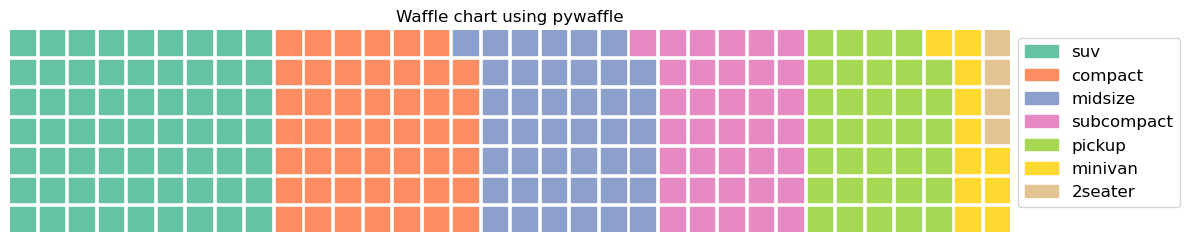

In [36]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


values = {k:v for k,v in zip(df["class"].value_counts().index, df["class"].value_counts().values)}


plt.figure(
    FigureClass = Waffle,
    rows = 7,
    columns = 34,
    values = values,
    legend = {'loc': 'upper left', 'bbox_to_anchor': (1, 1), "fontsize": "12"},
    figsize = (12, 10)
)

# set a title
plt.title("Waffle chart using pywaffle", fontsize = 12);

## Gráfico Torta (Pie Chart)

- A Pie Chart es una gráfico estadístico circular que puede mostrar sólo una serie de datos. El área del gráfico es el porcentaje total de los datos dados.

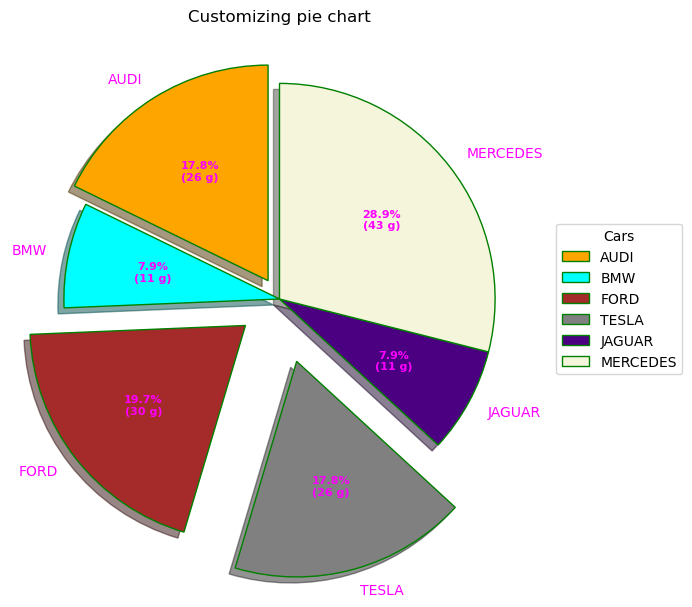

In [76]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt


# Creating dataset
cars = ['AUDI', 'BMW', 'FORD',
        'TESLA', 'JAGUAR', 'MERCEDES']

data = [27, 12, 30, 27, 12, 44]


# Creating explode data
explode = (0.1, 0.0, 0.2, 0.3, 0.0, 0.0)

# Creating color parameters
colors = ("orange", "cyan", "brown",
          "grey", "indigo", "beige")

# Wedge properties
wp = {'linewidth': 1, 'edgecolor': "green"}

# Creating autocpt arguments


def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


# Creating plot
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(data,
                                  autopct=lambda pct: func(pct, data),
                                  explode=explode,
                                  labels=cars,
                                  shadow=True,
                                  colors=colors,
                                  startangle=90,
                                  wedgeprops=wp,
                                  textprops=dict(color="magenta"))

# Adding legend
ax.legend(wedges, cars,
          title="Cars",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Customizing pie chart")

# show plot
plt.show()

- Usando el dataset

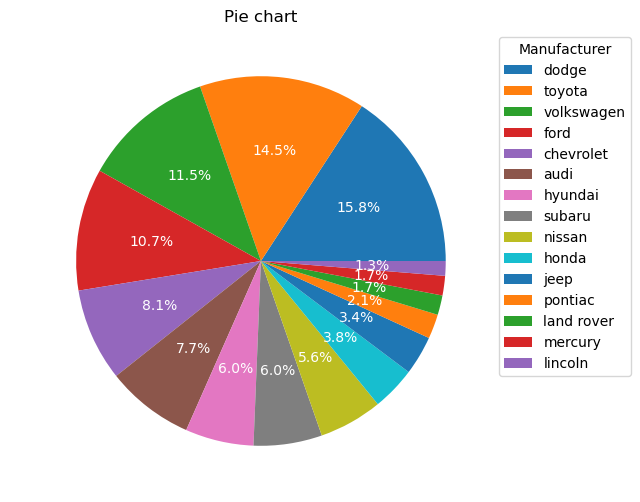

In [78]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)

d = df["manufacturer"].value_counts().to_dict()


fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot()


ax.pie(d.values(), # pass the values from our dictionary
       labels = d.keys(), # pass the labels from our dictonary
       autopct = '%1.1f%%', # specify the format to be plotted
       textprops = {'fontsize': 10, 'color' : "white"} # change the font size and the color of the numbers inside the pie
      )


# set the title
ax.set_title("Pie chart")

# set the legend and add a title to the legend
ax.legend(loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 10, title = "Manufacturer");

# More info: 
# https://en.wikipedia.org/wiki/Pie_chart

## Gráfico Treemap 

- Un gráfico Treemap es un tipo apropiado de visualización cuando el conjunto de datos se estructura en orden jerárquico con un trazado de árbol con raíces, ramas y ganglios. Permite mostrar información sobre una cantidad importante de datos de una manera muy eficiente en un espacio limitado.

(0.0, 100.0, 0.0, 100.0)

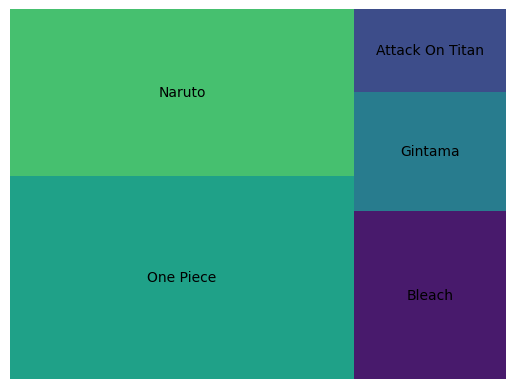

In [80]:
import squarify 
import matplotlib.pyplot as plt 

episode_data = [1004, 820, 366, 260, 180] 
anime_names = ["One Piece", "Naruto", "Bleach",  
               "Gintama", "Attack On Titan"] 
  
squarify.plot(episode_data, label=anime_names) 
  
plt.axis("off") 

- Usando el set de datos

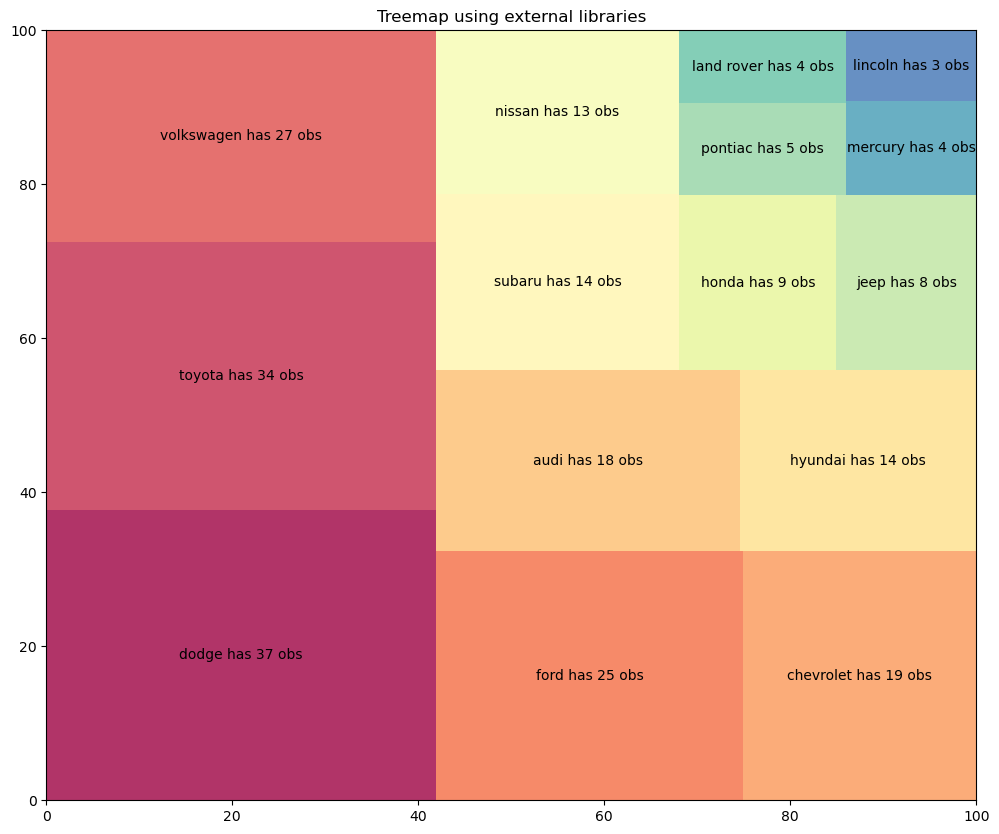

In [82]:
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


label_value = df["manufacturer"].value_counts().to_dict()


labels = ["{} has {} obs".format(class_, obs) for class_, obs in label_value.items()]


colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]


plt.figure(figsize = (12, 10))


squarify.plot(sizes = label_value.values(), label = labels,  color = colors, alpha = 0.8)


# add a title to the plot
plt.title("Treemap using external libraries");

# More info: 
# https://en.wikipedia.org/wiki/Treemapping

## Gráfico de barras

- Una gráfico de barras representa la categoría de datos con barras rectangulares con longitudes y alturas que son proporcionales a los valores que representan. Los gráficos de barra se pueden trazar horizontal o verticalmente. Un gráfico de barras describe las comparaciones entre las categorías discretas. Uno de los ejes de la parcela representa las categorías específicas que se están comparando, mientras que el otro eje representa los valores medidos correspondientes a esas categorías.

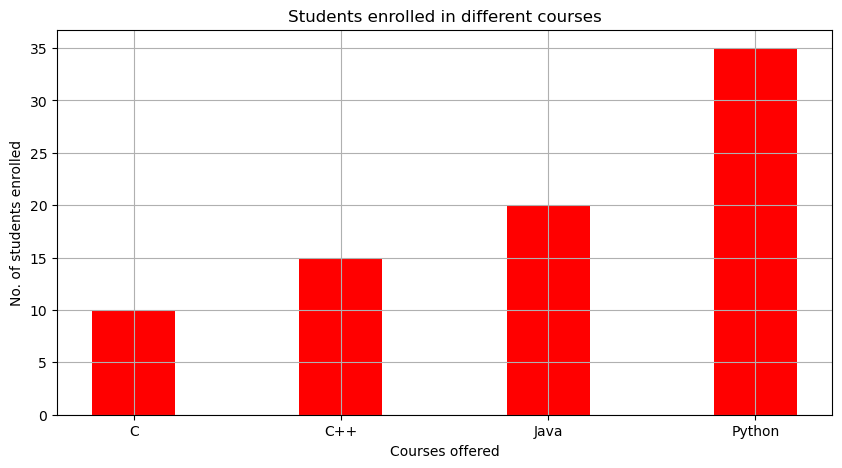

In [84]:
import numpy as np
import matplotlib.pyplot as plt 

 
# creating the dataset
data = {'C':10, 'C++':15, 'Java':20, 
        'Python':35}
courses = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='red', 
        width = 0.4)

plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.grid()
plt.show()

- Usando el set de datos

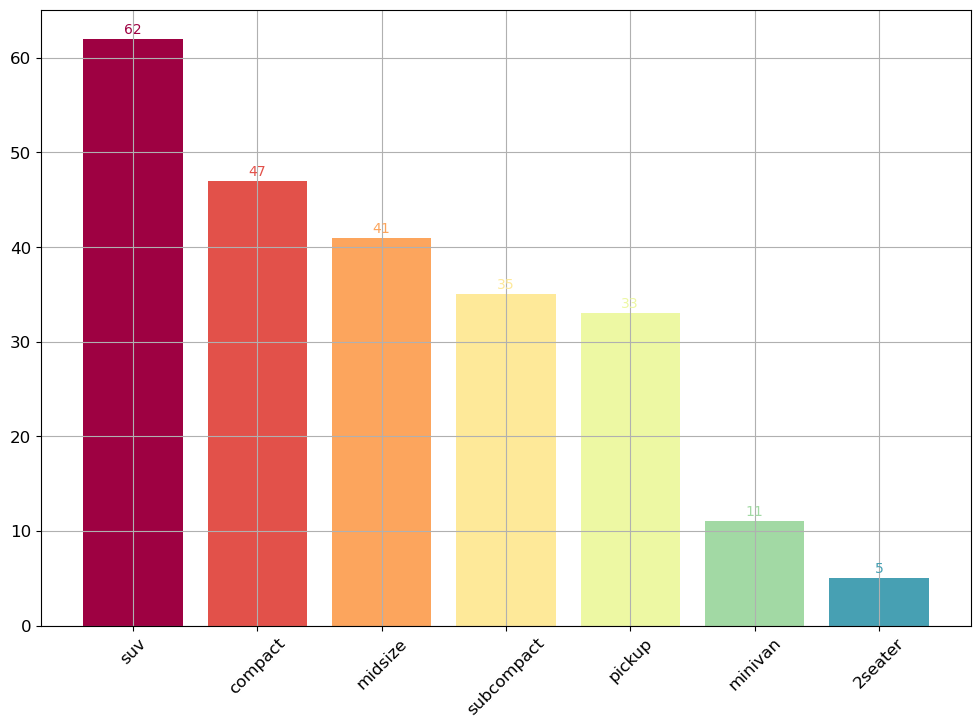

In [86]:
# get the data
PATH = "visual/mpg_ggplot2.csv"
df = pd.read_csv(PATH)


d = df["class"].value_counts().to_dict()

# create n colors based on the number of labels we have
colors = [plt.cm.Spectral(i/float(len(d.keys()))) for i in range(len(d.keys()))]


fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()


ax.bar(d.keys(), d.values(), color = colors)

# iterate over every x and y 
for i, (k, v) in enumerate(d.items()):
    ax.text(k, # where to put the text on the x coordinates
            v + 1, # where to put the text on the y coordinates
            v, # value to text
            color = colors[i], # color corresponding to the bar
            fontsize = 10, # fontsize
            horizontalalignment = 'center', # center the text to be more pleasant
            verticalalignment = 'center'
           )


ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)


# set a title for the plot
ax.set_title("", fontsize = 14);
plt.grid()

# More info: 
# https://en.wikipedia.org/wiki/Bar_chart

## Gráfico de series temporales

- Los gráficos de series temporales son datos marcados en algún tiempo. Cada punto del gráfico representa una medición en el tiempo y cantidad. Un gráfico de serie de tiempo los datos se conectan en orden cronológico por una línea recta que forma una sucesión de picos y valles. El eje x del gráfico se utiliza para representar intervalos de tiempo. En cambio el eje y se ubican los valores del parámetro  monitoreado.

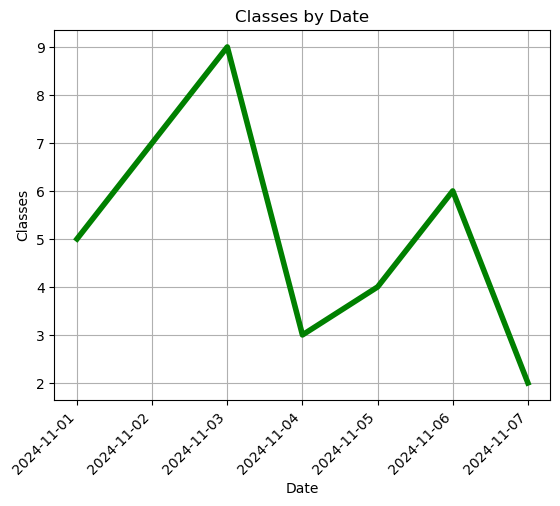

In [88]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
 
# create dataframe
 
dataframe = pd.DataFrame({'date_of_week': np.array([datetime.datetime(2024, 11, i+1)
                                                    for i in range(7)]),
                          'classes': [5, 7, 9, 3, 4, 6, 2]})
 
# Plotting the time series of given dataframe
plt.plot(dataframe.date_of_week, dataframe.classes,lw=4,c='g')
 
# Giving title to the chart using plt.title
plt.title('Classes by Date')
 
# rotating the x-axis tick labels at 30degree 
# towards right
plt.xticks(rotation=45, ha='right')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Classes')
plt.grid()

- Usando el dataset de AirPassengers.csv 

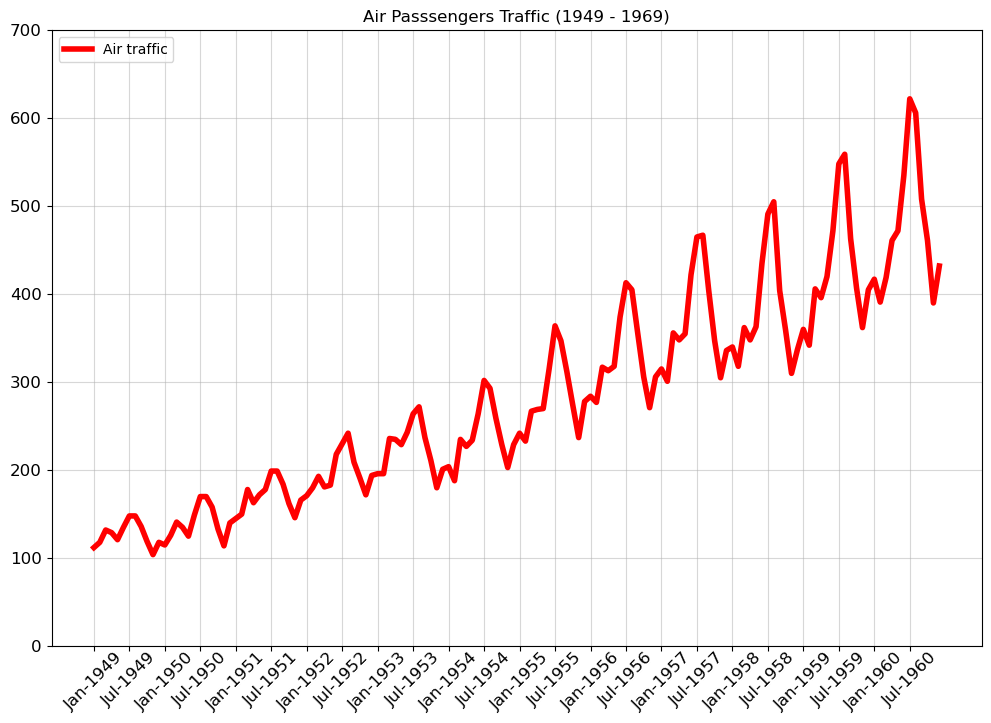

In [90]:
# get the data
PATH = 'visual/AirPassengers.csv'
df = pd.read_csv(PATH)


def create_date_tick(df):
    '''
    Converts dates from this format: Timestamp('1949-01-01 00:00:00')
    To this format: 'Jan-1949'
    '''
    df["date"] = pd.to_datetime(df["date"]) # convert to datetime
    df["month_name"] = df["date"].dt.month_name() # extracts month_name
    df["month_name"] = df["month_name"].apply(lambda x: x[:3]) # passes from January to Jan
    df["year"] = df["date"].dt.year # extracts year
    df["new_date"] = df["month_name"].astype(str) + "-" + df["year"].astype(str) # Concatenaes Jan and year --> Jan-1949

# create the time column and the xtickslabels column
create_date_tick(df)

# get the y values (the x is the index of the series)
y = df["value"]


fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()


ax.plot(y, color = "red", alpha = 1, label = "Air traffic",lw=4)


ax.grid(alpha = .5)

# change the ylim
ax.set_ylim(0, 700)

# get the xticks and the xticks labels
xtick_location = df.index.tolist()[::6]
xtick_labels = df["new_date"].tolist()[::6]

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location)

# chage the label from '1949-01-01 00:00:00' to this 'Jan-1949'
ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})

# change the size of the font of the x and y axis
ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# set the title and the legend of the plot
ax.set_title("Air Passsengers Traffic (1949 - 1969)", fontsize = 12)
ax.legend(loc = "upper left", fontsize = 10);

## Seies de tiempo con Cimas y Valles 
- Se puede gráficar las series temporales y además anotar el momento en el que se llega a la cima y al valle

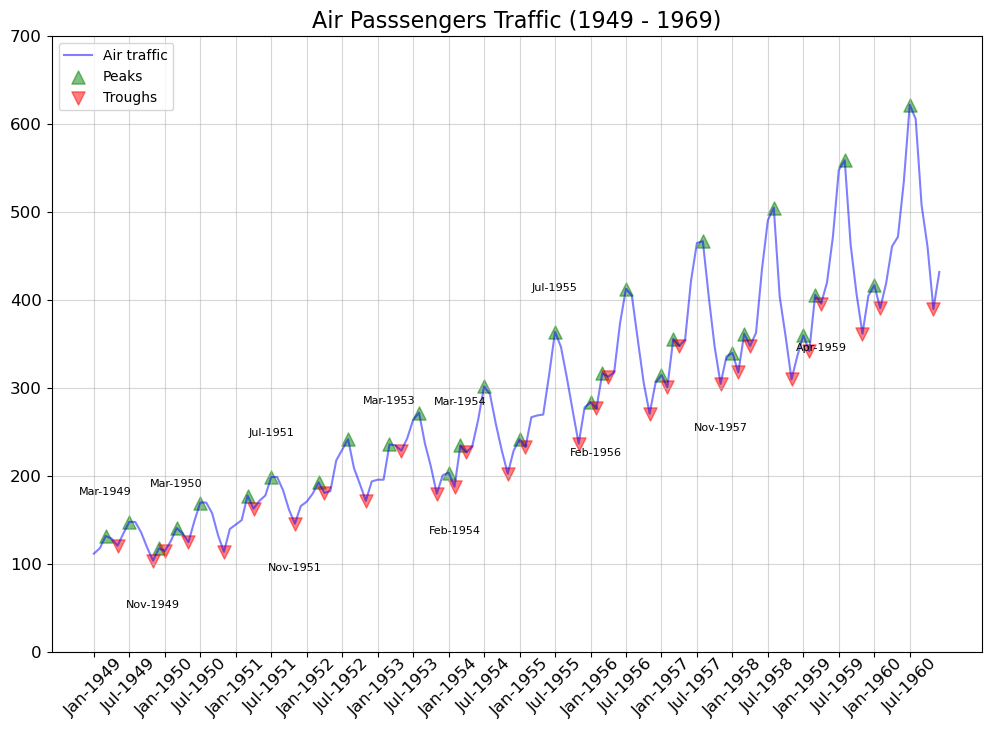

In [92]:
# get the data
PATH = 'visual/AirPassengers.csv'
df = pd.read_csv(PATH)


def create_date_tick(df):
    '''
    Converts dates from this format: Timestamp('1949-01-01 00:00:00')
    To this format: 'Jan-1949'
    '''
    df["date"] = pd.to_datetime(df["date"]) # convert to datetime
    df["month_name"] = df["date"].dt.month_name() # extracts month_name
    df["month_name"] = df["month_name"].apply(lambda x: x[:3]) # passes from January to Jan
    df["year"] = df["date"].dt.year # extracts year
    df["new_date"] = df["month_name"].astype(str) + "-" + df["year"].astype(str) # Concatenaes Jan and year --> Jan-1949

# create the time column and the xtickslabels column
create_date_tick(df)

# get the y values (the x is the index of the series)
y = df["value"]

# find local maximum INDEX using scipy library
max_peaks_index, _ = find_peaks(y, height=0) 

# find local minimum INDEX using numpy library
doublediff2 = np.diff(np.sign(np.diff(-1*y))) 
min_peaks_index = np.where(doublediff2 == -2)[0] + 1


fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()

# plot the data using matplotlib
ax.plot(y, color = "blue", alpha = .5, label = "Air traffic")

# we have the index of max and min, so we must index the values in order to plot them
ax.scatter(x = y[max_peaks_index].index, y = y[max_peaks_index].values, marker = "^", s = 90, color = "green", alpha = .5, label = "Peaks")
ax.scatter(x = y[min_peaks_index].index, y = y[min_peaks_index].values, marker = "v", s = 90, color = "red", alpha = .5, label = "Troughs")

# iterate over some max and min in order to annotate the values
for max_annot, min_annot in zip(max_peaks_index[::3], min_peaks_index[1::5]):
    
    # extract the date to be plotted for max and min
    max_text = df.iloc[max_annot]["new_date"]
    min_text = df.iloc[min_annot]["new_date"]
    
    # add the text
    ax.text(df.index[max_annot], y[max_annot] + 50, s = max_text, fontsize = 8, horizontalalignment = 'center', verticalalignment = 'center')
    ax.text(df.index[min_annot], y[min_annot] - 50, s = min_text, fontsize = 8, horizontalalignment = 'center', verticalalignment = 'center')


# change the ylim
ax.set_ylim(0, 700)

# get the xticks and the xticks labels
xtick_location = df.index.tolist()[::6]
xtick_labels = df["new_date"].tolist()[::6]

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location)

ax.grid(alpha = .5)

# chage the label from '1949-01-01 00:00:00' to this 'Jan-1949'
ax.set_xticklabels(xtick_labels, rotation=45, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})

# change the size of the font of the x and y axis
ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# set the title and the legend of the plot
ax.set_title("Air Passsengers Traffic (1949 - 1969)", fontsize = 16)
ax.legend(loc = "upper left", fontsize = 10);

## Gráfico ACF & PACF

- En el análisis de series temporales, la Función de Autocorrelación (ACF) y la Función de Autocorrelación Parcial (PACF) ayudan a identificar patrones, tendencias y el orden de los modelos autoregresivos, convirtiéndolos en herramientas esenciales en campos como finanzas, meteorología y economía.
- Aquí, se compara una serie contra sí misma pero con algunos retrasos de tiempo.
- Básicamente, se trata de gráficos que resumen gráficamente la fuerza de una relación entre una serie temporal y su versión retrasada.

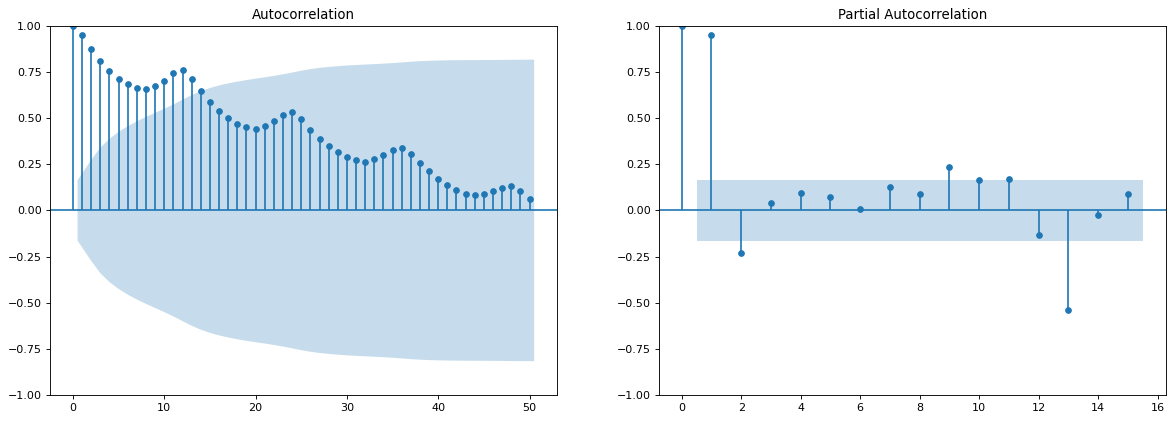

In [94]:
PATH = 'visual/AirPassengers.csv'
df = pd.read_csv(PATH)


fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (18,6), dpi = 80)

plot_acf(df["value"], ax = ax1, lags = 50)
plot_pacf(df["value"], ax = ax2, lags = 15);

# More info: 
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

## Gráfico X-Correlación 

- Usando la dataset mortality.csv para calcular la correlación X de mdeaths y fdeaths en series de tiempo

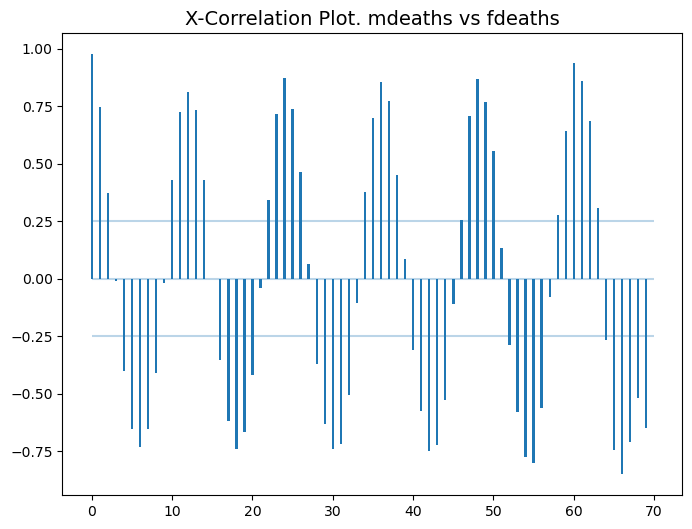

In [96]:
# get the data
PATH = "visual/mortality.csv"
df = pd.read_csv(PATH)


# using this solution to calculate the cross correlation of 2 series
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
def crosscorr(datax, datay, lag=0):
    """ 
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

# get the cross correlation
xcov_monthly = [crosscorr(df["mdeaths"], df["fdeaths"], lag = i) for i in range(70)]

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot()

ax.bar(x = np.arange(len(xcov_monthly)), height = xcov_monthly, width = .3)


ax.hlines(0.25, 0, len(xcov_monthly), alpha = .3)
ax.hlines(0, 0, len(xcov_monthly), alpha = .3)
ax.hlines(-0.25, 0, len(xcov_monthly), alpha = .3)

# set the title
ax.set_title("X-Correlation Plot. mdeaths vs fdeaths", fontsize = 14)

# change the x and y ticks size
ax.tick_params(axis = 'x', labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 10);

# More info: 
# https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9?gi=abf39ccba21b

## Matriz de Correlación

- Ahora vale la pena llamar nuevamente la atención de una matriz de correlación (CM) que ayuda a entender cómo diferentes variables interactúan entre sí.
- Comparemos las siguientes tres variables: en una Matriz de correlación con Pandas (dataset de iris).

In [98]:
import pandas as pd
import numpy as np
from sklearn import datasets

# Cargar y preparar datos
dataset = datasets.load_iris()
dataframe = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
dataframe["target"] = dataset.target

# Calcular matriz de correlación
mtrx = dataframe.corr()

# Crear máscara para ocultar la parte superior de la matriz
mask = np.zeros_like(mtrx, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Aplicar la máscara usando .where()
mtrx = mtrx.where(~mask)

# Mostrar como estilo
styled = (
    mtrx
    .style
    .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
    .highlight_null(null_color='#f1f1f1')
    .format(precision=2)
)
styled

- sns.heatmap matriz de correlación set de datos iris

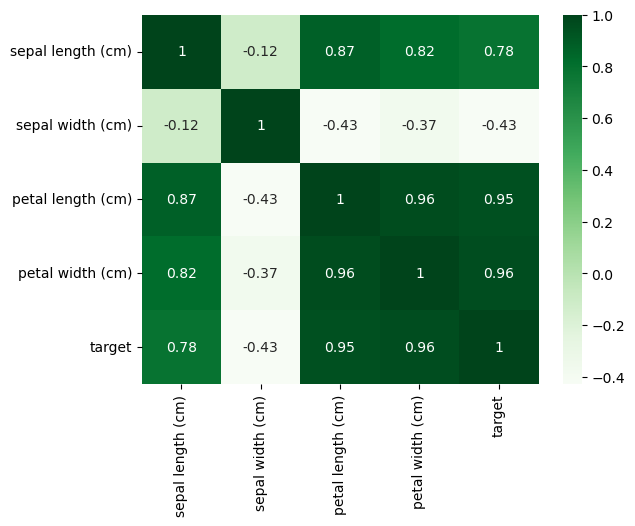

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd

dataset = datasets. load_iris()
dataframe = pd. DataFrame(data=dataset. data, columns=dataset. feature_names)
dataframe["target"] = dataset. target
matrix = dataframe.corr()

# plotting correlation matrix
sns.heatmap(matrix, cmap="Greens", annot=True)
plt.show()

- sns.heatmap matriz de correlación dataset de propinas

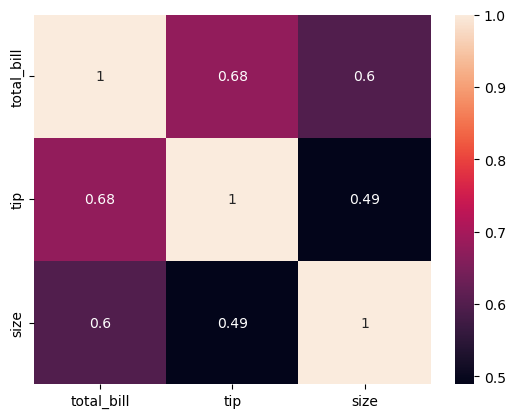

In [102]:
import seaborn as sns
 
# checking correlation using heatmap
#Loading dataset

tips = sns.load_dataset("tips")
tips1=tips[['total_bill','tip','size']]

 
#plotting the heatmap for correlation
ax = sns.heatmap(tips1.corr(), annot=True)

## Descomposición de Series de Tiempo

- La descomposición de las series temporales se puede considerar como una técnica estadística utilizada para desglosar un conjunto de datos en sus componentes individuales como tendencia, estacionalidad, cíclica y residuos.

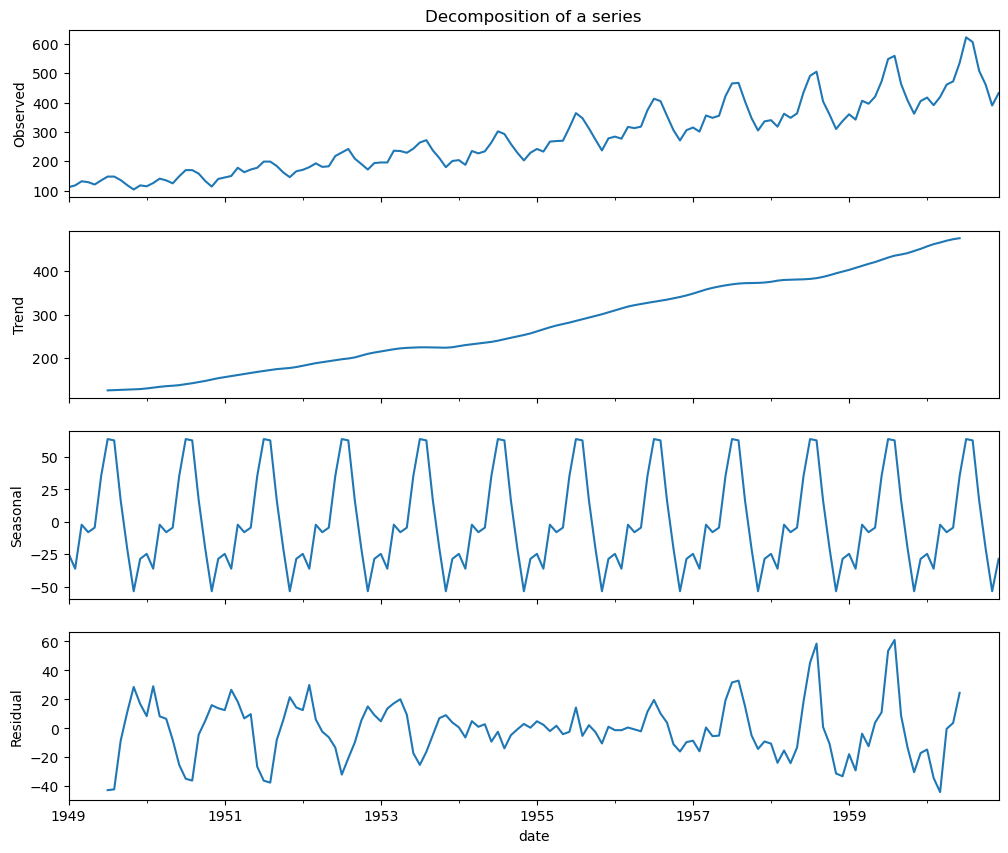

In [104]:
# get the data
PATH = 'visual/AirPassengers.csv'
df = pd.read_csv(PATH)


def create_date_tick(df):
    '''
    Converts dates from this format: Timestamp('1949-01-01 00:00:00')
    To this format: 'Jan-1949'
    '''
    df["date"] = pd.to_datetime(df["date"]) # convert to datetime
    df.set_index("date", inplace = True)
    df["date"] = df.index
    df["month_name"] = df["date"].dt.month_name() # extracts month_name
    df["month_name"] = df["month_name"].apply(lambda x: x[:3]) # passes from January to Jan
    df["year"] = df["date"].dt.year # extracts year
    df["new_date"] = df["month_name"].astype(str) + "-" +df["year"].astype(str) # Concatenaes Jan and year --> Jan-1949


create_date_tick(df)


result = seasonal_decompose(df["value"])


fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (12,10))


# https://stackoverflow.com/questions/45184055/how-to-plot-multiple-seasonal-decompose-plots-in-one-figure


# plot the original data
result.observed.plot(ax = axes[0], legend = False)
axes[0].set_ylabel('Observed')
axes[0].set_title("Decomposition of a series")

# plot the trend
result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel('Trend')

# plot the seasonal part
result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel('Seasonal')

# plot the residual
result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel('Residual')


xtick_location = df.index.tolist()[::6]
xtick_labels = df["new_date"].tolist()[::6]

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location)

# chage the label from '1949-01-01 00:00:00' to this 'Jan-1949'
ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'});

## Serie de tiempo múltiple

- Todavía podemos utilizar el método plot() para trazar un gráfico de línea de múltiples series temporales, siempre que los índices de todos los DataFrames estén alineados.

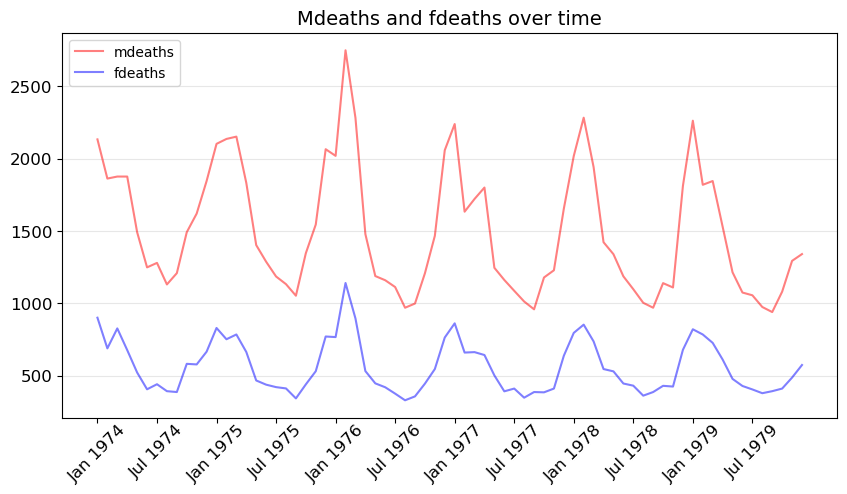

In [106]:
# get the data
PATH = "visual/mortality.csv"
df = pd.read_csv(PATH)

# set the date column to be the index
df.set_index("date", inplace = True)

fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()


ax.plot(df["mdeaths"], color = "red", alpha = .5, label = "mdeaths")
ax.plot(df["fdeaths"], color = "blue", alpha = .5, label = "fdeaths")


# get the xticks and the xticks labels
xtick_location = df.index.tolist()[::6]
xtick_labels = df.index.tolist()[::6]

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, rotation=45, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'});

# change the x and y ticks to be smaller
ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# add legend, a title and grid to make it look nicer
ax.legend(loc = "upper left", fontsize = 10)
ax.set_title("Mdeaths and fdeaths over time", fontsize = 14)
ax.grid(axis = "y", alpha = .3)

# More info: 
# https://study.com/academy/lesson/time-series-plots-definition-features.html

## Gráficos de Series de Tiempo con doble Eje

- Gráficos de series temporales de doble eje permite elegir dos escalas verticales para que el gráfico en la página sea equivalente a dibujar dos series indexadas, pero manteniendo la asignación significativa a la escala de las variables originales.

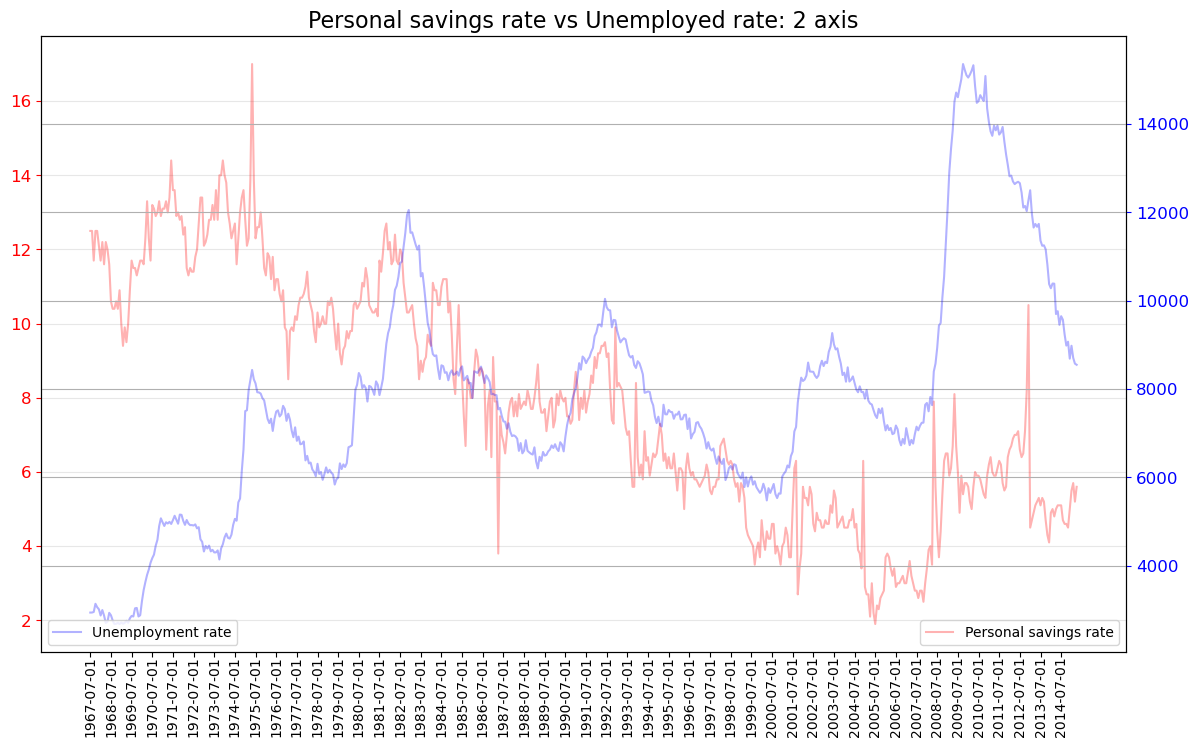

In [108]:
# get the data
PATH = "visual/economics.csv"
df = pd.read_csv(PATH)

# set the date column to be the index
df.set_index("date", inplace = True)


x_1 = df["psavert"]
x_2 = df["unemploy"]


fig = plt.figure(figsize = (14, 8))
ax = fig.add_subplot()


ax.plot(x_1, color = "red", alpha = .3, label = "Personal savings rate")

plt.legend(loc="lower right")


ax2 = ax.twinx()

ax2.plot(x_2, color = "blue", alpha = .3, label = "Unemployment rate")

plt.legend(loc="lower left")


xtick_location = df.index.tolist()[::12]
xtick_labels = df.index.tolist()[::12]


ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, rotation = 90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'});

# change the x and y ticks to be smaller for the main axis and for the secondary axis
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 12,colors='r')
ax2.tick_params(axis = 'y', labelsize = 12,colors='b')

# set a title and a grid
ax.set_title("Personal savings rate vs Unemployed rate: 2 axis", fontsize = 16)
ax.grid(axis = "y", alpha = .3)
plt.grid()

# More info: 
# https://study.com/academy/lesson/time-series-plots-definition-features.html

## Series de Tiempo y bandas de error

- Las bandas de error continuas son una representación gráfica de error o incertidumbre como una región sombreada alrededor de un rastro principal, en lugar de  arras de error discretas.

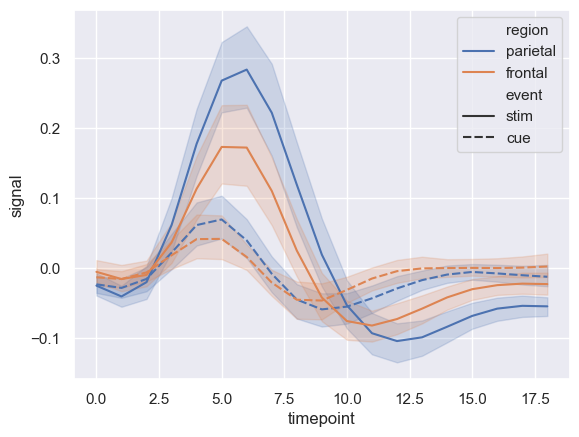

In [110]:
#seaborn components used: set_theme(), load_dataset(), lineplot()

import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)
plt.show()

- Un ejemplo más realista de series temporales con bandas usando el dataset user_orders_hourofday.csv

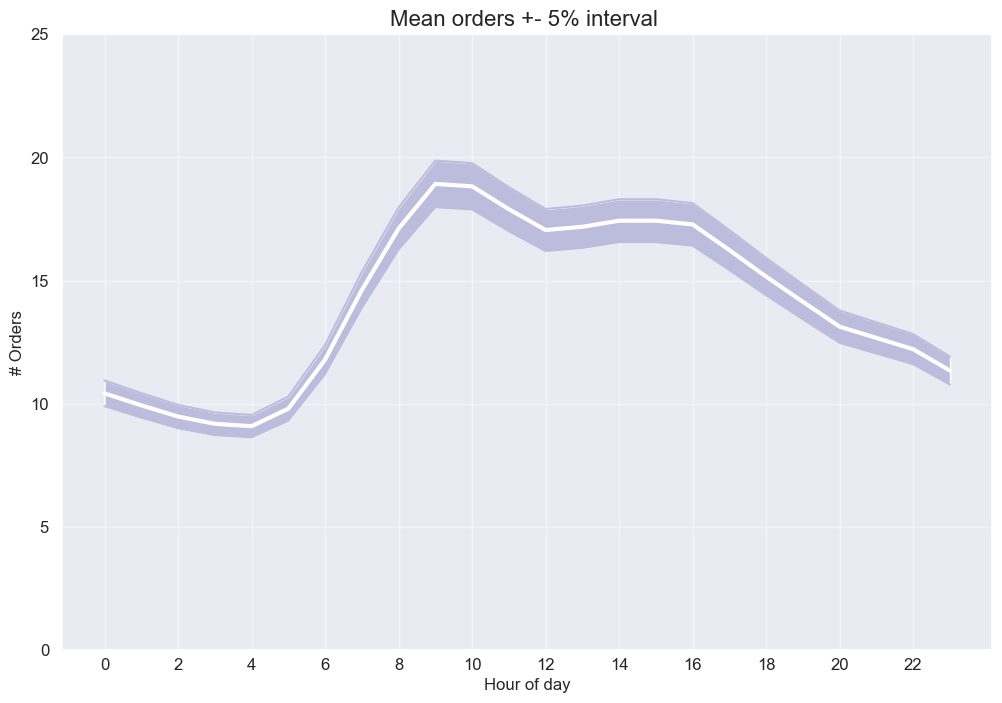

In [112]:
# get the data
url = "https://raw.githubusercontent.com/selva86/datasets/refs/heads/master/user_orders_hourofday.csv"
df = leer_csv_desde_url(url)

gb_df = df.groupby(["order_hour_of_day"])["quantity"].mean().to_frame()


x = gb_df["quantity"]
x_lower = x*0.95
x_upper = x*1.05


fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()


ax.plot(x, color = "white", lw = 3)
ax.plot(x_lower, color = "#bcbddc")
ax.plot(x_upper, color = "#bcbddc")


ax.fill_between(x.index, x, x_lower, where = x > x_lower, facecolor='#bcbddc', interpolate = True)
ax.fill_between(x.index, x, x_upper, where = x_upper > x, facecolor='#bcbddc', interpolate = True)


ax.set_ylim(0, 25)

# set the x and y labels
ax.set_xlabel("Hour of day")
ax.set_ylabel("# Orders")

# get the xticks and the xticks labels
xtick_location = gb_df.index.tolist()[::2]
xtick_labels = gb_df.index.tolist()[::2]

# set the xticks to be every 2'th entry
# every 2 months
ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline', "fontsize":"12"})

# change the x and y tick size
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)

# add a title and a gridline
ax.set_title("Mean orders +- 5% interval ", fontsize = 16)
ax.grid(axis = "y", alpha = .5)
ax.grid(axis = "x", alpha = .5)

## Gráfico de Área apilado

- Un gráfico de área apilado muestra la evolución de una variable numérica para varios grupos de un conjunto de datos.

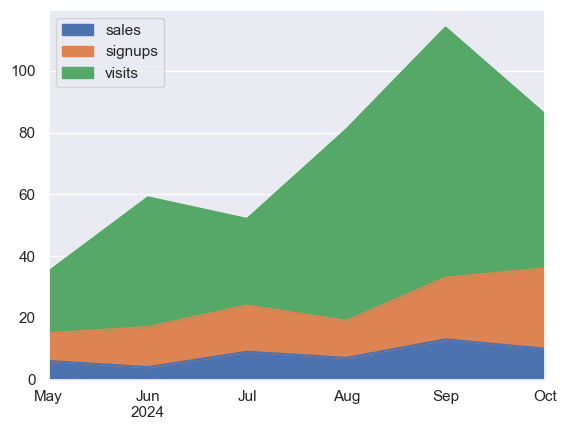

In [114]:
df = pd.DataFrame({
    'sales': [6, 4, 9, 7, 13, 10],
    'signups': [9,13, 15, 12, 20, 26],
    'visits': [20, 42, 28, 62, 81, 50],
}, index=pd.date_range(start='2024/05/01', end='2024/11/01',
                       freq='M'))

ax = df.plot.area()

- Usando el data set nightvisitors.csv

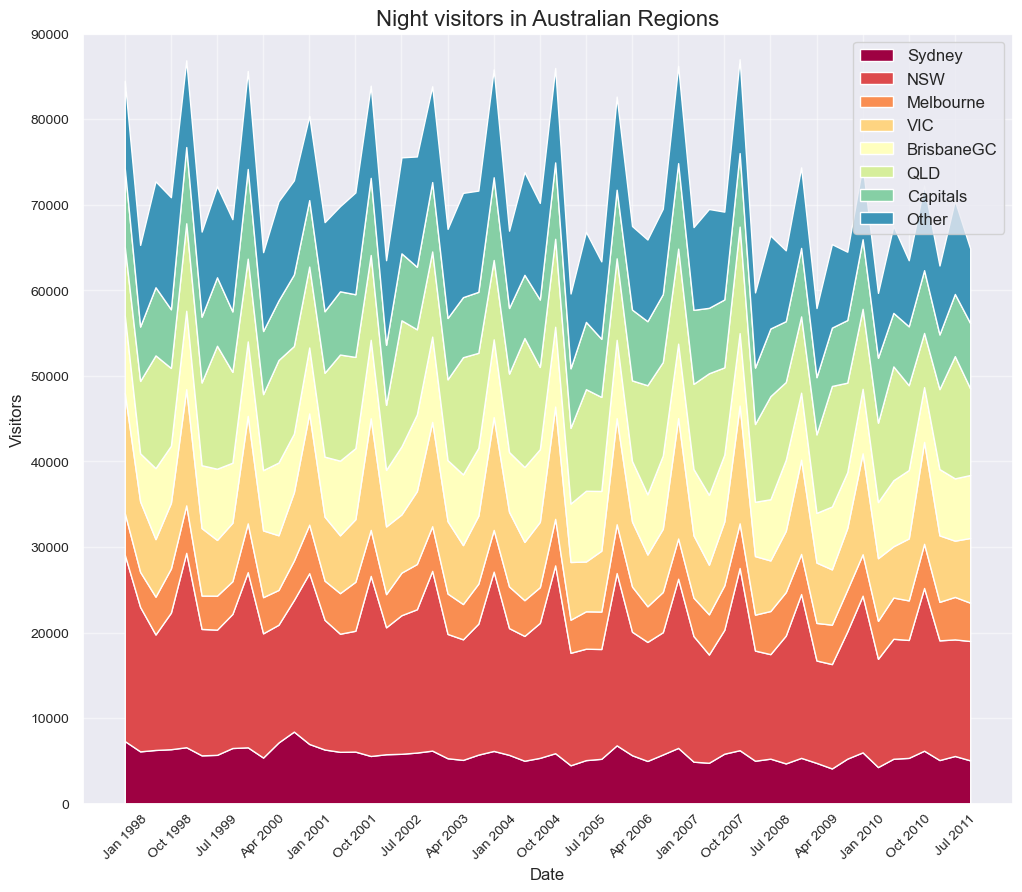

In [116]:
# get the data
url = "https://raw.githubusercontent.com/selva86/datasets/refs/heads/master/nightvisitors.csv"
df = leer_csv_desde_url(url)

# set the data as index of the df
df.set_index("yearmon", inplace = True)


x = df.index
y = [df[col].values for col in df.columns]


labels = df.columns

# prepare some colors for each group to be ploted
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]


fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()


ax.stackplot(x,y, labels = labels, colors = colors)


xtick_location = df.index.tolist()[::3]
xtick_labels = df.index.tolist()[::3]


ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline', "fontsize":"12"})


ax.tick_params(axis = 'x', labelsize = 10, rotation = 45)
ax.tick_params(axis = 'y', labelsize = 10)


ax.set_xlabel("Date", fontsize = 12)
ax.set_ylabel("Visitors", fontsize = 12)

# change the ylim
ax.set_ylim(0, 90000)

# set a title and a legend
ax.set_title("Night visitors in Australian Regions", fontsize = 16)
ax.legend(fontsize =12);
ax.grid(axis = "y", alpha = .5)
ax.grid(axis = "x", alpha = .5)

## Gráfico de área desbloqueado

- Una gráfico de área muestra datos cuantitativos visualmente. Esta función envuelve la función de área de matplotlib.
- Aquí, las variables de la zona se apilan por defecto. Para producir una parcela sin apilar.

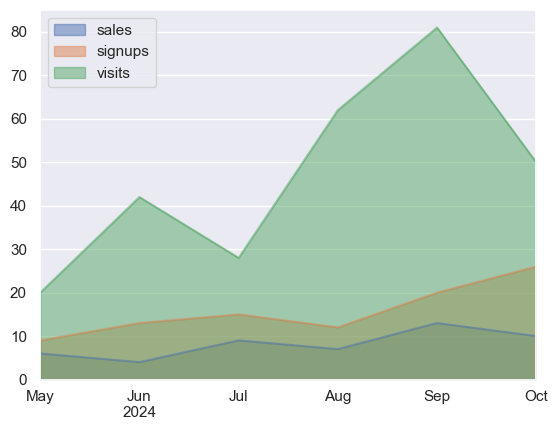

In [118]:
df = pd.DataFrame({
    'sales': [6, 4, 9, 7, 13, 10],
    'signups': [9,13, 15, 12, 20, 26],
    'visits': [20, 42, 28, 62, 81, 50],
}, index=pd.date_range(start='2024/05/01', end='2024/11/01',
                       freq='M'))
ax = df.plot.area(stacked=False)

- Usando el dataset de economics.csv

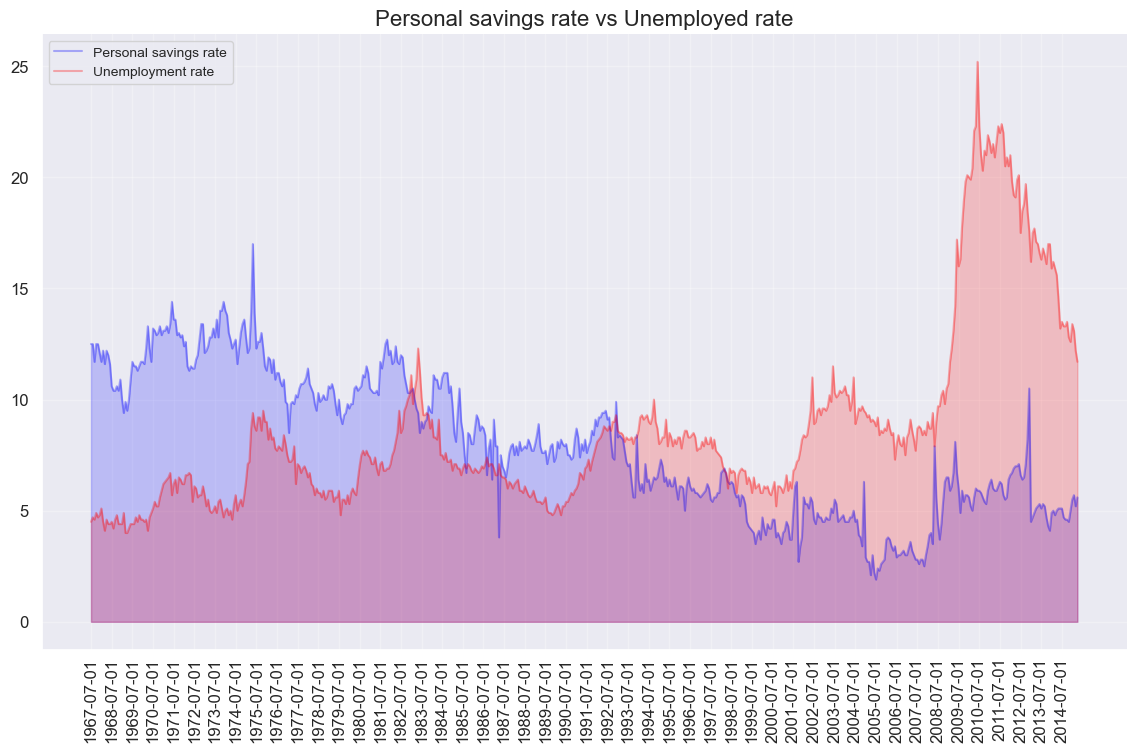

In [120]:
# get the data
PATH = "visual/economics.csv"
df = pd.read_csv(PATH)


df.set_index("date", inplace = True)


x = df["psavert"]
y = df["uempmed"]

fig = plt.figure(figsize = (14, 8))
ax = fig.add_subplot()


ax.plot(x, color = "blue", alpha = .3, label = "Personal savings rate")
ax.plot(y, color = "red", alpha = .3, label = "Unemployment rate")

# fill the areas between the plots and the x axis
# this can create overlapping areas between lines
ax.fill_between(x.index, 0, x, color = "blue", alpha = .2)
ax.fill_between(x.index, 0, y, color = "red", alpha = .2)


# set the title
ax.set_title("Personal savings rate vs Unemployed rate", fontsize = 16)


xtick_location = df.index.tolist()[::12]
xtick_labels = df.index.tolist()[::12]


ax.set_xticks(xtick_location)
ax.set_xticklabels(xtick_labels, rotation = 90, fontdict = {'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})


ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)


ax.spines["right"].set_color("None")
ax.spines["top"].set_color("None")


ax.legend(fontsize = 10)
ax.grid(axis = "y", alpha = .3);
ax.grid(axis = "x", alpha = .3);

## Calendario Heatmap

- Importar la libreri calmap para crear mapas de calor en un calendario a partir de los datos de la serie de tiempo de Pandas.

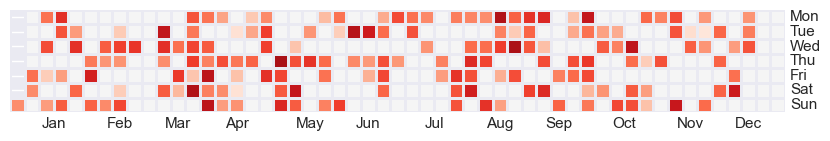

In [122]:
import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import pandas as pd
import calmap

all_days = pd.date_range('1/15/2022', periods=700, freq='D')
days = np.random.choice(all_days, 500)
plt.figure(figsize=(10,8))
events = pd.Series(np.random.randn(len(days)), index=days)
calmap.yearplot(events, year=2023)
plt.show()

- O se puede usar calendarplot() para graficar todos los años como sub-gráficos en una figura:

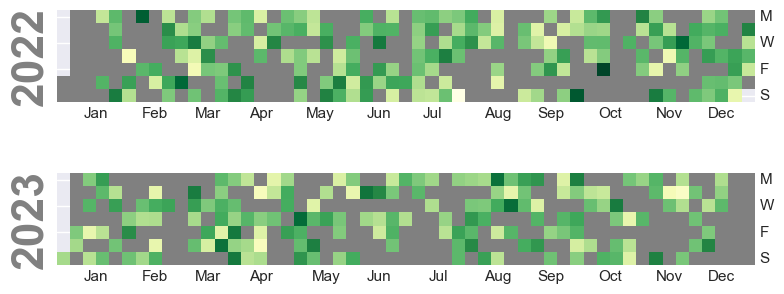

In [124]:
calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='YlGn',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(8, 4)))
plt.show()

## Gráfico estacional

- El gráfico estacional se puede utilizar para comparar cómo se realizó una serie de tiempo el mismo día de la temporada anterior (año / mes / semana, etc).

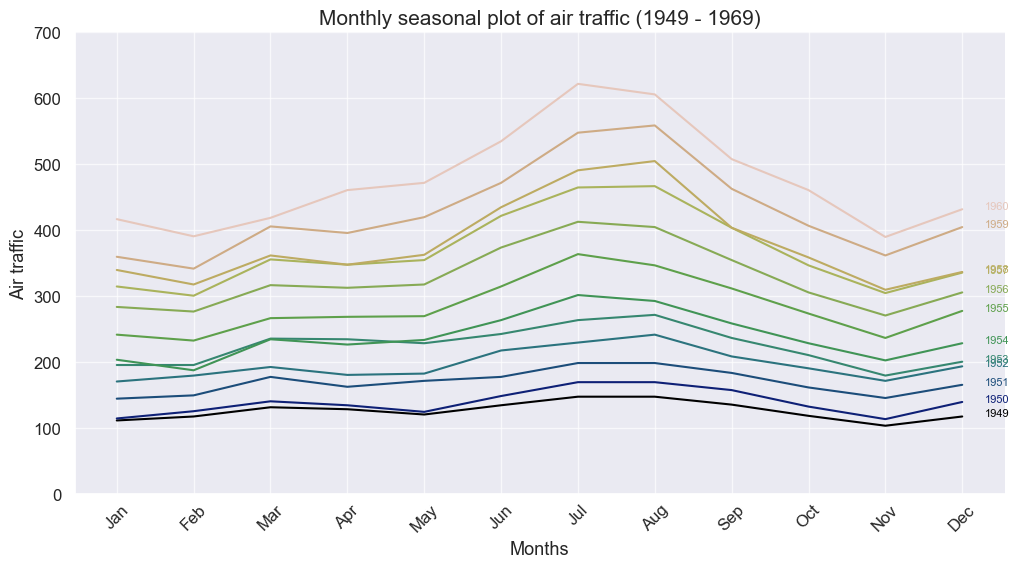

In [126]:
# get the data
PATH = "visual/AirPassengers.csv"
df = pd.read_csv(PATH)


index_ = [i for i in range(1, 13)]*12

# set the index into the dataframe
df["index_"] = index_

# create a dictionary with the months name 
months_ = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
d = {k:v for k,v in zip(index_[:12], months_)}

# convert to datetime the date column
df["date"] = pd.to_datetime(df["date"])

# extract the year using pandas datatime (dt)
df["year"] = df["date"].dt.year

# drop the date
df.drop("date", inplace = True, axis = 1)

# create a pivot table
# traspose the rows into columns, where the columns name are the year to plot
df = df.pivot(values = "value", columns = "year", index = "index_")

# create n colors for each season
colors = [plt.cm.gist_earth(i/float(len(df.columns))) for i in range(len(df.columns))]


x = df.index


fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()


for col, color in zip(df.columns, colors):
    # get the y to plot
    y = df[col]
    
    # plot the data using seaborn
    ax.plot(x, y, label = col, c = color)
    
    # get the x and y to annotate
    x_annotate = x[-1]
    y_annotate = df.iloc[11][col]
    
    
    ax.text(x_annotate + 0.3, y_annotate, col, fontsize = 8, c = color)


ax.set_xlabel("Months", fontsize = 13)
ax.set_ylabel("Air traffic", fontsize = 13)

# extract the x ticks location
xtick_location = df.index.tolist()


months = [d[tick] for tick in xtick_location]


ax.set_xticks(xtick_location)
ax.set_xticklabels(months, rotation = 45, fontdict = {'horizontalalignment': 'center', 'verticalalignment': 'center_baseline', "fontsize":"12"})


ax.tick_params(axis = 'y', labelsize = 12)


ax.set_ylim(0, 700)


ax.spines["right"].set_color("None")
ax.spines["top"].set_color("None")


ax.grid(axis = "y", alpha = .7)
ax.grid(axis = "x", alpha = .7)
# set the title for the plot
ax.set_title("Monthly seasonal plot of air traffic (1949 - 1969)", fontsize = 15);

## Dendrograma

- El dendrogramo ilustra cómo cada racimo se compone dibujando un vínculo en forma de U entre una base  y sus hijos. La parte superior del enlace en U indica una fusión de racimo. Las dos patas del enlace en U indican qué cúmulos se fusionaron. La longitud de las dos patas del enlace en U representa la distancia entre los grupos de niños.

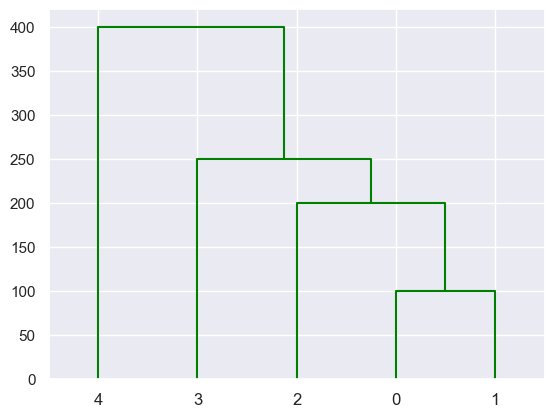

In [128]:
# Python program to plot the hierarchical 
# clustering dendrogram using SciPy
 
# Import the python libraries
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
 
# Create an array
x = np.array([100., 200., 300., 400., 500., 250.,
              450., 280., 450., 750.])
 
# Plot the hierarchical clustering as a dendrogram.
temp = hierarchy.linkage(x, 'single')
plt.figure()
 
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=.9)

- Creación del dendrograma del conjunto de datos USArrests.csv 

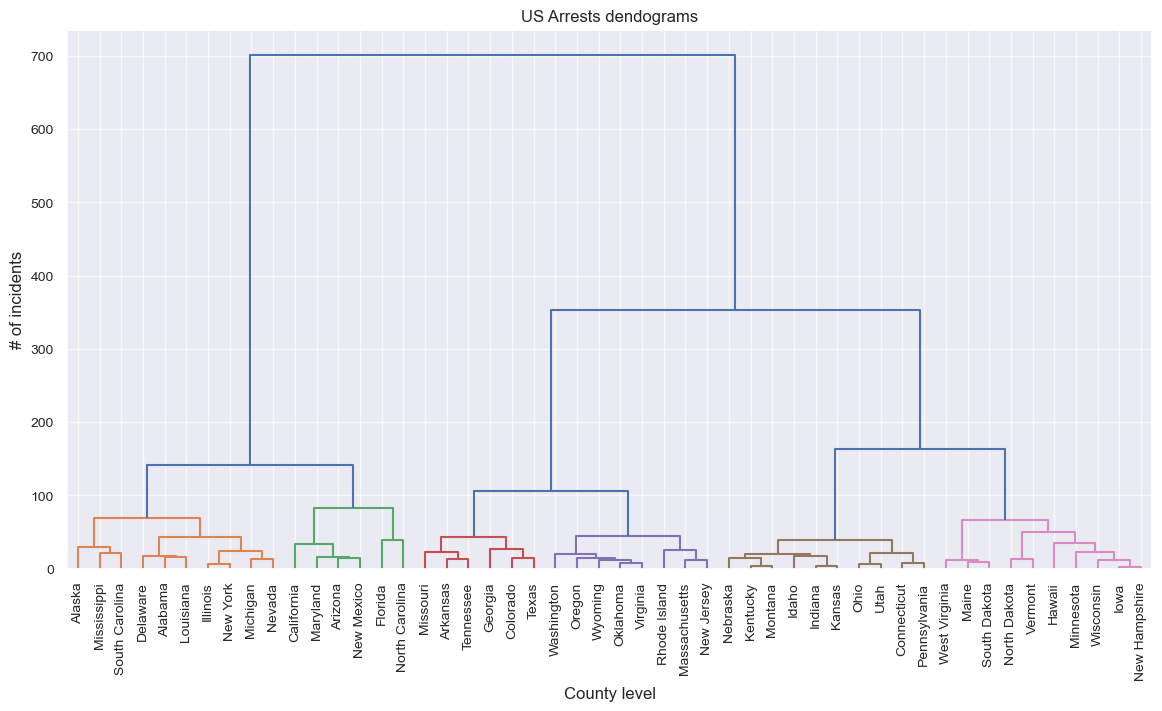

In [130]:
# get the data
PATH = "visual/USArrests.csv"
df = pd.read_csv(PATH)


fig = plt.figure(figsize = (14, 7))

# plot the data using the scipy package
dend = shc.dendrogram(shc.linkage(df[['Murder', 'Assault', 'UrbanPop', 'Rape']], method = 'ward'), 
                      labels = df["State"].values, 
                      color_threshold = 100)


ax = plt.gca()


ax.set_xlabel("County level")
ax.set_ylabel("# of incidents")


ax.tick_params("x", labelsize = 10)
ax.tick_params("y", labelsize = 10)


ax.grid(axis = "y", alpha = .7)
ax.grid(axis = "x", alpha = .7)

# set a title
ax.set_title("US Arrests dendograms");

## Gráfico de Cluster

- Hay diferentes maneras de etiquetar un gráfico de dispersión con diferentes grupos (o clusters) de puntos de datos utilizando los paquetes Python matplotlib y seaborn. Estos métodos de etiquetado son útiles para representar los resultados de la agrupación de algoritmos, como la agrupación K-medios.

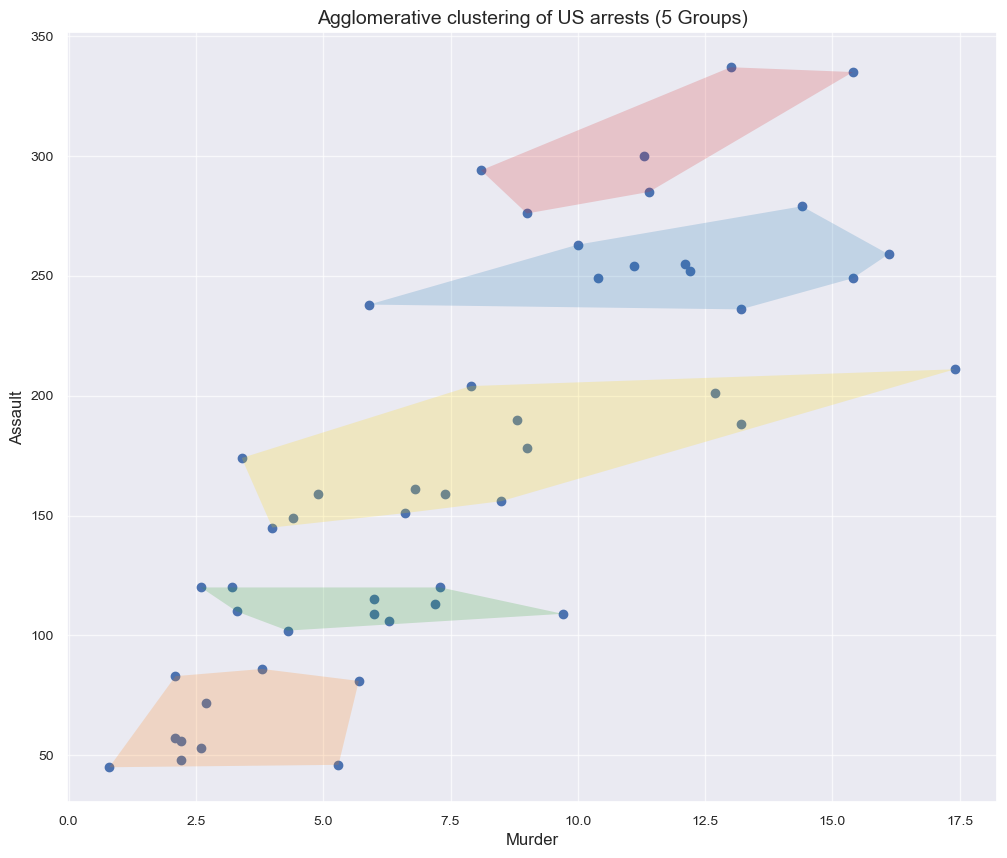

In [133]:
# get the data
PATH = "visual/USArrests.csv"
df = pd.read_csv(PATH)


x = df["Murder"]
y = df["Assault"]

# Create out cluster using the AgglomerativeClustering from sklearn
#https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html
cluster = AgglomerativeClustering(n_clusters = 5, # notice that we specify the number of "optimal" clusters
                                  metric='euclidean', # use the euclidean distance to compute similarity. The closer the better.
                                  linkage = 'ward'
                                 )  

# fit and predict the clusters based on this data
cluster.fit_predict(df[['Murder', 'Assault', 'UrbanPop', 'Rape']])  



fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()


ax.scatter(x, y)

# Encircle
def encircle(x,y, ax = None, **kw):
    '''
    Takes an axes and the x and y and draws a polygon on the axes.
    This code separates the differents clusters
    '''
    # get the axis if not passed
    if not ax: ax=plt.gca()
    
    # concatenate the x and y arrays
    p = np.c_[x,y]
    
    # to calculate the limits of the polygon
    hull = ConvexHull(p)
    
    # create a polygon from the hull vertices
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    
    # add the patch to the axes
    ax.add_patch(poly)

# use our cluster fitted before to draw the clusters borders like we did at the beginning of the kernel
# basically go over each cluster and add a patch to the axes
encircle(df.loc[cluster.labels_ == 0, 'Murder'], df.loc[cluster.labels_ == 0, 'Assault'], ec = "k", fc = "gold", alpha = 0.2, linewidth = 0)
encircle(df.loc[cluster.labels_ == 1, 'Murder'], df.loc[cluster.labels_ == 1, 'Assault'], ec = "k", fc = "tab:blue", alpha = 0.2, linewidth = 0)
encircle(df.loc[cluster.labels_ == 2, 'Murder'], df.loc[cluster.labels_ == 2, 'Assault'], ec = "k", fc = "tab:red", alpha = 0.2, linewidth = 0)
encircle(df.loc[cluster.labels_ == 3, 'Murder'], df.loc[cluster.labels_ == 3, 'Assault'], ec = "k", fc = "tab:green", alpha = 0.2, linewidth = 0)
encircle(df.loc[cluster.labels_ == 4, 'Murder'], df.loc[cluster.labels_ == 4, 'Assault'], ec = "k", fc = "tab:orange", alpha = 0.2, linewidth = 0)


ax.tick_params("x", labelsize = 10)
ax.tick_params("y", labelsize = 10)


ax.set_xlabel("Murder", fontsize = 12)
ax.set_ylabel("Assault", fontsize = 12)


ax.grid(axis = "y", alpha = .7)
ax.grid(axis = "x", alpha = .7)

# set a title for the plot
ax.set_title("Agglomerative clustering of US arrests (5 Groups)", fontsize = 14);

# More info: 
# https://en.wikipedia.org/wiki/Cluster_analysis

## Las Curvas de Andrews

- Las curvas de Andrews se utilizan para visualizar datos de alta dimensiones mediante el mapeo de cada observación en una función. Conserva los medios, la distancia y las varianzas.
- Trazar curvas de Andrews en un gráfico se puede hacer usando el método andrews-curves() del módulo de ploting().

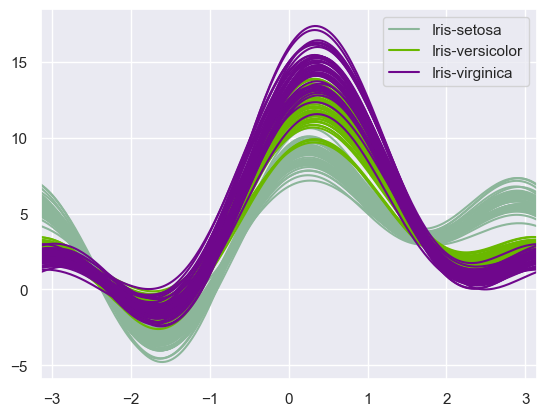

In [136]:
# importing various package 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
  
# making data frame from csv file 
df = pd.read_csv( 
    'https://raw.github.com/pandas-dev/'
    'pandas/master/pandas/tests/io/data/csv/iris.csv'
) 
  
# Creating Andrews curves 
x = pd.plotting.andrews_curves(df, 'Name') 
  
# plotting the Curve 
x.plot() 
  
# Display 
plt.grid()
plt.show()

## Coordenadas paralelas

- Los datos de 1D o 3D se pueden ver relativamente rectos utilizando tipos de trama tradicionales. Dimensiones por encima de 4D, sin embargo, se vuelven cada vez más difíciles de visualizar. Afortunadamente, los gráficos de coordenadas paralelas proporcionan un mecanismo para ver los resultados de dimensiones superiores.

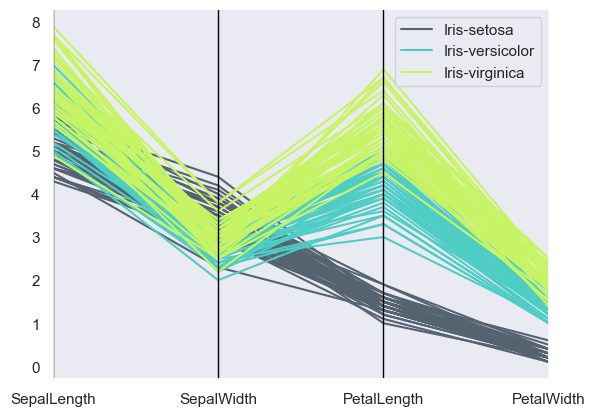

In [141]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/pandas-dev/'
    'pandas/main/pandas/tests/io/data/csv/iris.csv'
)
pd.plotting.parallel_coordinates(
    df, 'Name', color=('#556270', '#4ECDC4', '#C7F464')
) 
plt.show()

- Aquí hay un ejemplo de gráficos con los datos de Fisher's Iris (después de correcciones de errores)

/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/3326211948.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_yticklabels(labels)
/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/3326211948.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_yticklabels(labels)
/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/3326211948.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_yticklabels(labels)
/var/folders/1p/tx085xn96hv_w2n0b330dkz00000gn/T/ipykernel_16344/3326211948.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axx.set_yticklabels(labels)
/var/folders/1p/tx085xn96hv_w2n0b330

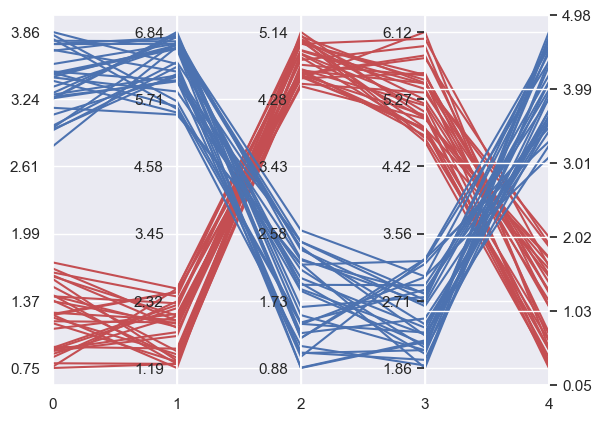

In [144]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def parallel_coordinates(data_sets, style=None):

    dims = len(data_sets[0])
    x    = range(dims)
    fig, axes = plt.subplots(1, dims-1, sharey=False)

    if style is None:
        style = ['r-']*len(data_sets)

    # Calculate the limits on the data
    min_max_range = list()
    for m in zip(*data_sets):
        mn = min(m)
        mx = max(m)
        if mn == mx:
            mn -= 0.5
            mx = mn + 1.
        r  = float(mx - mn)
        min_max_range.append((mn, mx, r))

    # Normalize the data sets
    norm_data_sets = list()
    for ds in data_sets:
        nds = [(value - min_max_range[dimension][0]) / 
                min_max_range[dimension][2] 
                for dimension,value in enumerate(ds)]
        norm_data_sets.append(nds)
    data_sets = norm_data_sets

    # Plot the datasets on all the subplots
    for i, ax in enumerate(axes):
        for dsi, d in enumerate(data_sets):
            ax.plot(x, d, style[dsi])
        ax.set_xlim([x[i], x[i+1]])

    # Set the x axis ticks 
    for dimension, (axx,xx) in enumerate(zip(axes, x[:-1])):
        axx.xaxis.set_major_locator(ticker.FixedLocator([xx]))
        ticks = len(axx.get_yticklabels())
        labels = list()
        step = min_max_range[dimension][2] / (ticks - 1)
        mn   = min_max_range[dimension][0]
        for i in range(ticks):
            v = mn + i*step
            labels.append('%4.2f' % v)
        axx.set_yticklabels(labels)


    # Move the final axis' ticks to the right-hand side
    axx = plt.twinx(axes[-1])
    dimension += 1
    axx.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    ticks = len(axx.get_yticklabels())
    step = min_max_range[dimension][2] / (ticks - 1)
    mn   = min_max_range[dimension][0]
    labels = ['%4.2f' % (mn + i*step) for i in range(ticks)]
    axx.set_yticklabels(labels)

    # Stack the subplots 
    plt.subplots_adjust(wspace=0)

    return plt


if __name__ == '__main__':
    import random
    base  = [0,   0,  5,   5,  0]
    scale = [1.5, 2., 1.0, 2., 2.]
    data = [[base[x] + random.uniform(0., 1.)*scale[x]
            for x in range(5)] for y in range(30)]
    colors = ['r'] * 30

    base  = [3,   6,  0,   1,  3]
    scale = [1.5, 2., 2.5, 2., 2.]
    data.extend([[base[x] + random.uniform(0., 1.)*scale[x]
                 for x in range(5)] for y in range(30)])
    colors.extend(['b'] * 30)

    parallel_coordinates(data, style=colors).show()